In [2]:
library(terra)
library(rgeos)
library(leaflet)
library(sp)
library(gdalUtils)
library(rgdal)
library(tidyverse)


terra 1.6.47

Loading required package: sp

rgeos version: 0.6-1, (SVN revision 692)
 GEOS runtime version: 3.9.1-CAPI-1.14.2 
 Please note that rgeos will be retired during 2023,
plan transition to sf functions using GEOS at your earliest convenience.
 GEOS using OverlayNG
 Linking to sp version: 1.4-5 
 Polygon checking: TRUE 


rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.2, released 2021/09/01
Path to GDAL shared files: 
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.1, March 5th, 2021, [PJ_VERSION: 801]
Path to PROJ shared files: /opt/conda/envs/r-with-gdal/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.


Attaching package: ‘rgdal’


The following object is masked from ‘package:terra’:

    project


Warnin

In [97]:
VALIDATE_RASTER <- function(src_fn, ref_fn, lc_fn, LC_FOCAL_VAL = 10, REF_BAND_NUM = 1 ){
    
    # Function to validate raster based on original notebook
    # Paul Montesano Jan 2023
    # this function requires raster that have ALREADY been wrangled into the same grid (extent, res, proj)
    # To do this, use build_stack.py
    # Notebook: /projects/shared-buckets/nathanmthomas/my-public-bucket/validate_agb
    
    # Output results data frame
    results=data.frame(ID=NA
                  ,RMSE=NA
                  ,BIAS=NA
                  ,RMSE_rel=NA
                  ,BIAS_rel=NA
                      ,SRC_FN=src_fn
                      ,REF_FN=ref_fn)
    
    AGB_ICESAT = terra::rast(src_fn)
    AGB_ref = terra::rast(ref_fn)[[REF_BAND_NUM]]

    # Mask out ref AGB < 0
    AGB_ref[AGB_ref<0] <- NA
    
    # Remove where ESA worldcover land cover != LC_FOCAL_VAL ( trees value = 10)
    lc = terra::rast(lc_fn)
    lc[lc != LC_FOCAL_VAL] <- NA

   # plot(AGB_ref)

    # mask out non-forest pixels
    AGB_ICESAT_masked= terra::mask(AGB_ICESAT, AGB_ref)
    AGB_ICESAT_masked = terra::mask(AGB_ICESAT_masked, lc)
    #plot(AGB_ICESAT_masked)

    # compute residuals between the two maps
    residuals= AGB_ref-AGB_ICESAT_masked[[AGB_band]]
    
#     # Get count of pixels
#     r_count <- classify(residuals, cbind(-Inf, Inf, 1))
#     names(r_count) <- names(r_count)
#     print(cellStats(r_count, 'sum'))
    
    print('Map of residuals: ref - src')
    plot(residuals, breaks=c(0,10,20,30,40,50,400))
    #hist(residuals)

    # compute RMSE and BIAS
    RMSE=as.numeric(sqrt(global(residuals^2, fun="mean", na.rm=T)))
    BIAS= as.numeric(global(residuals, fun="mean", na.rm=T))

    # compute relative RMSE and BIAS as % of the mean
    RMSE_rel= RMSE/as.numeric(global(AGB_ref, fun="mean", na.rm=T))*100
    BIAS_rel= BIAS/as.numeric(global(AGB_ref, fun="mean", na.rm=T))*100

    results$RMSE=RMSE
    results$BIAS=BIAS
    results$RMSE_rel=RMSE_rel
    results$BIAS_rel=BIAS_rel
    
    return(results)
    
}

In [39]:
# Here is to define the band number in the ICESAT-2 BIOMASS product that corresponds to the AGB
AGB_band=1

[1] "Map of residuals: ref - src"
[1] "Map of residuals: ref - src"


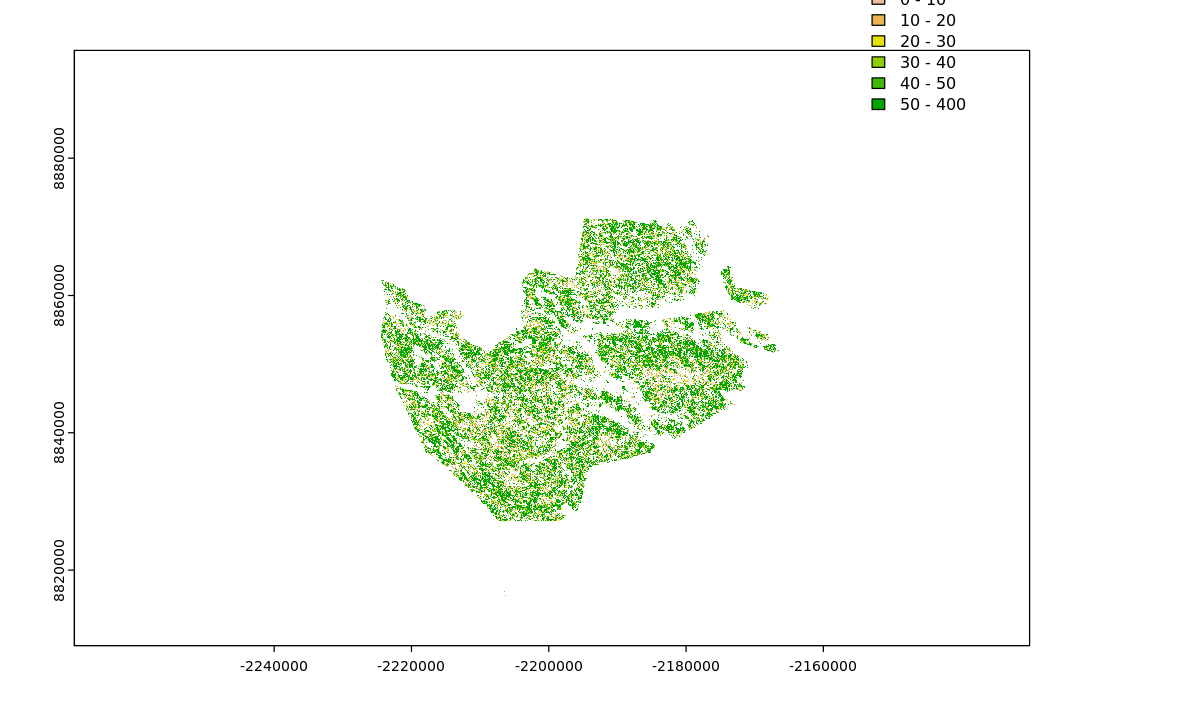

[1] "Map of residuals: ref - src"


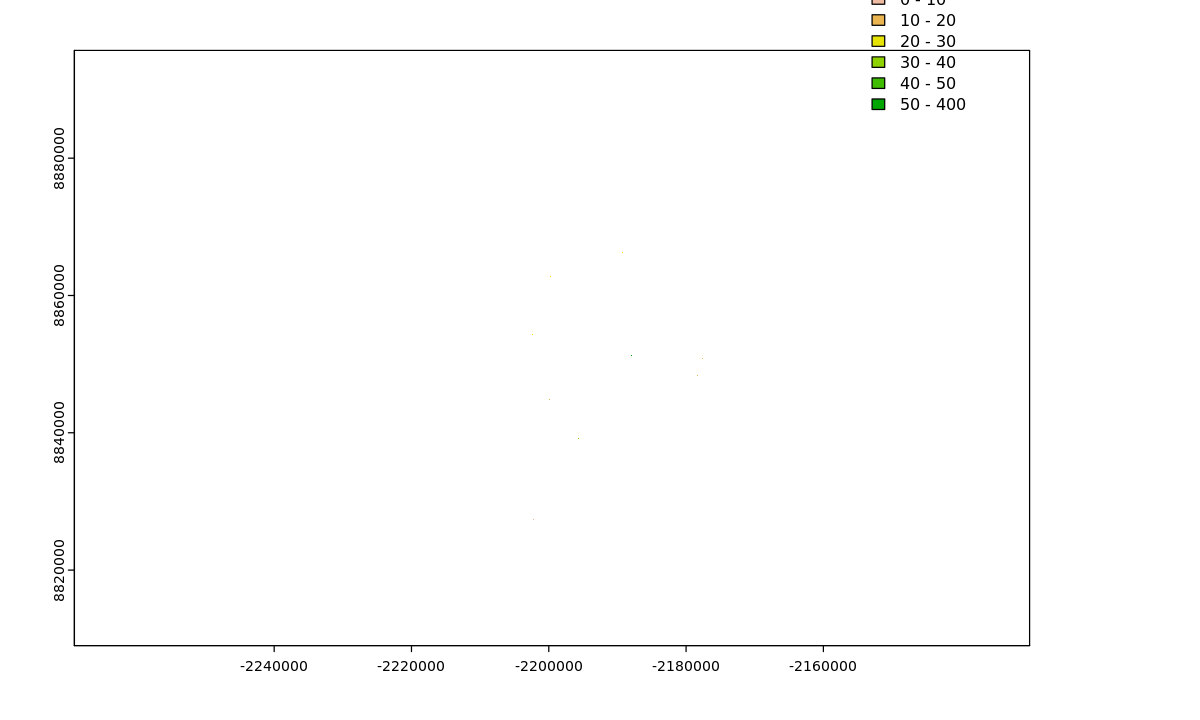

[1] "Map of residuals: ref - src"


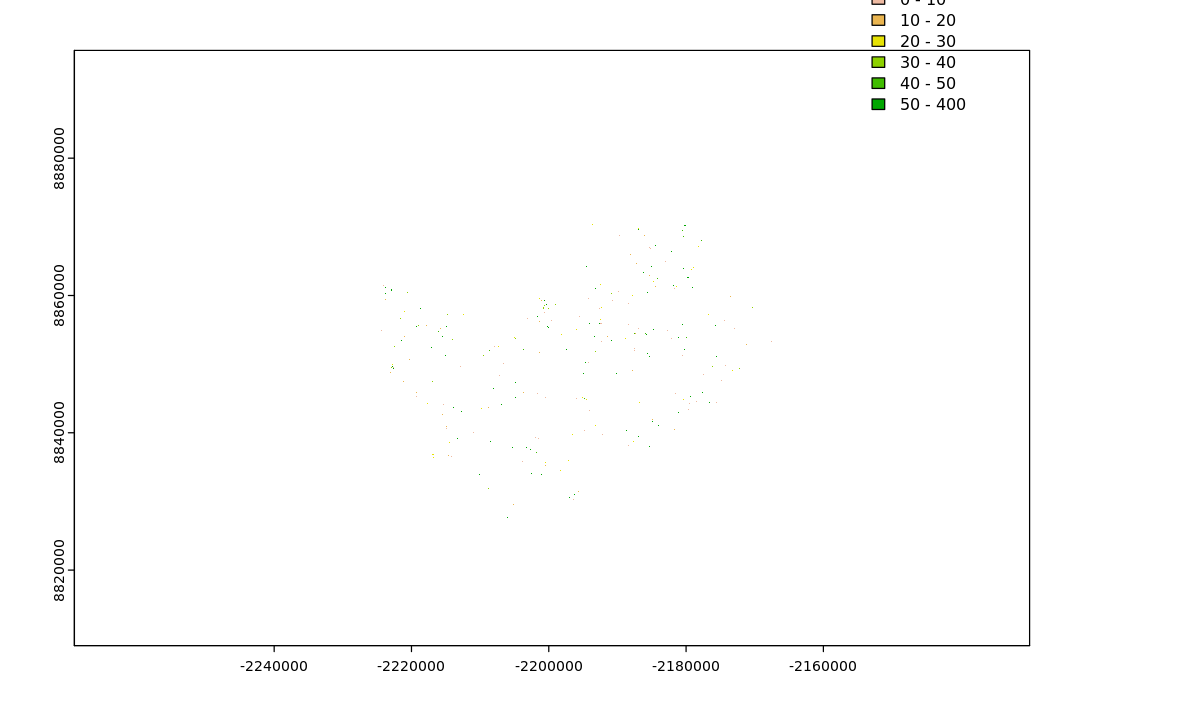

[1] "Map of residuals: ref - src"


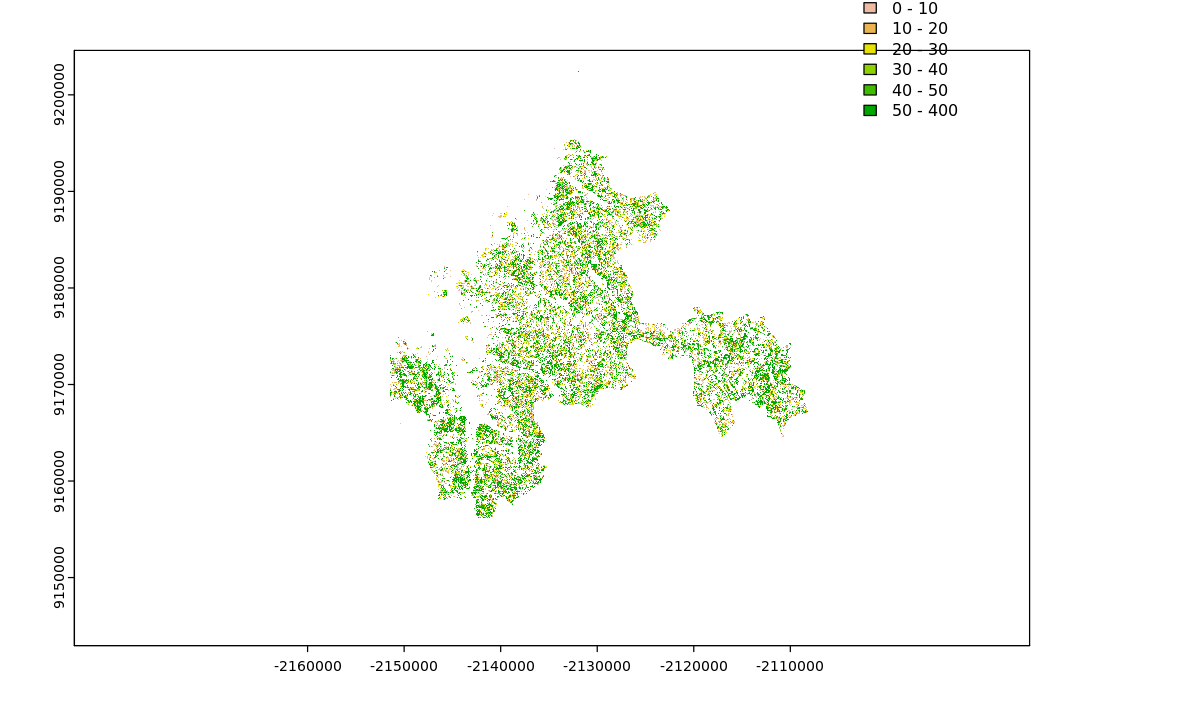

[1] "Map of residuals: ref - src"


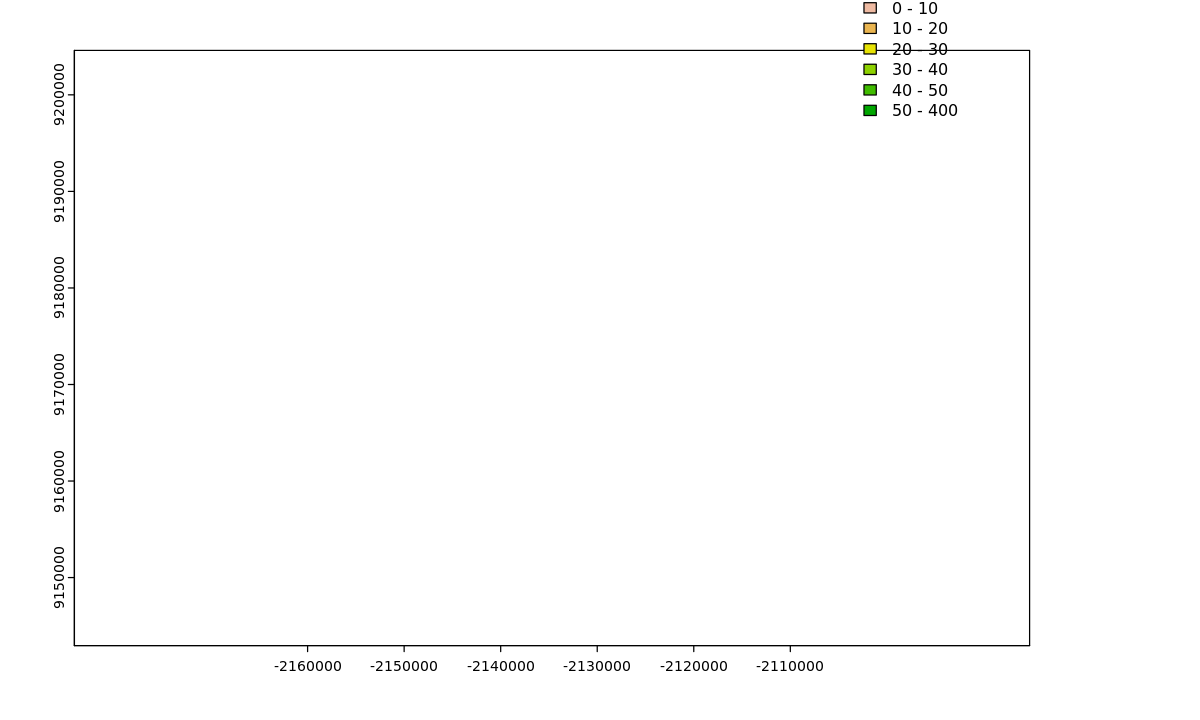

[1] "Map of residuals: ref - src"


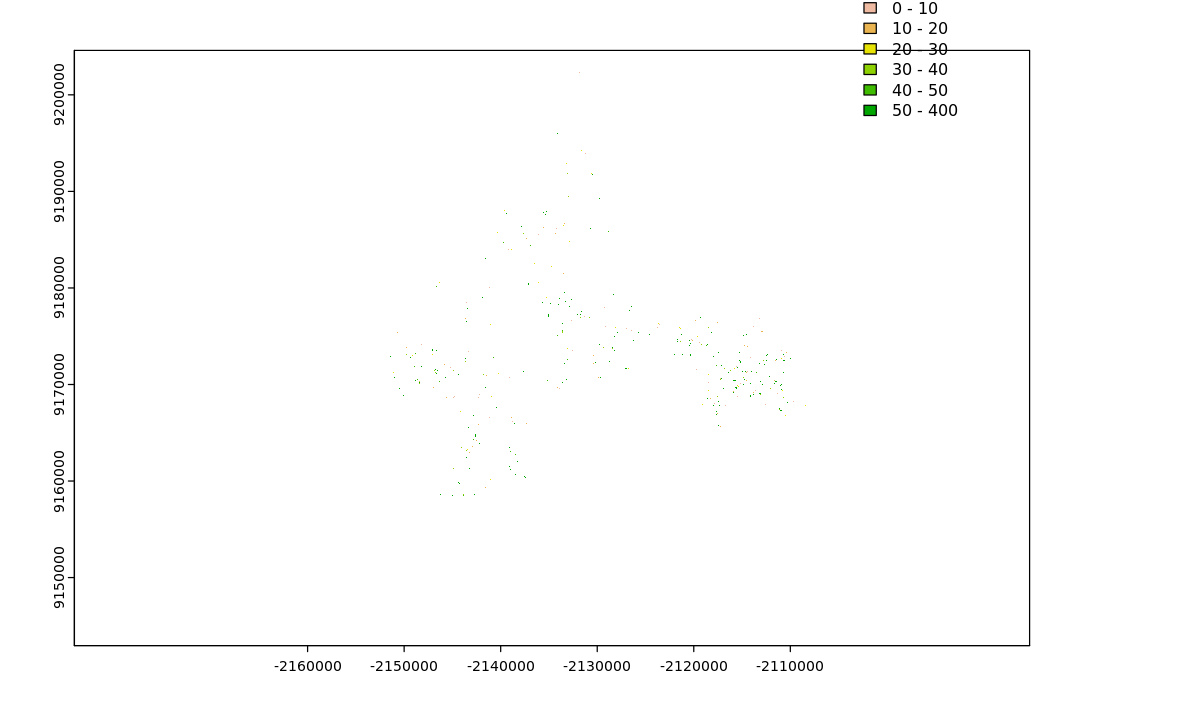

[1] "Map of residuals: ref - src"


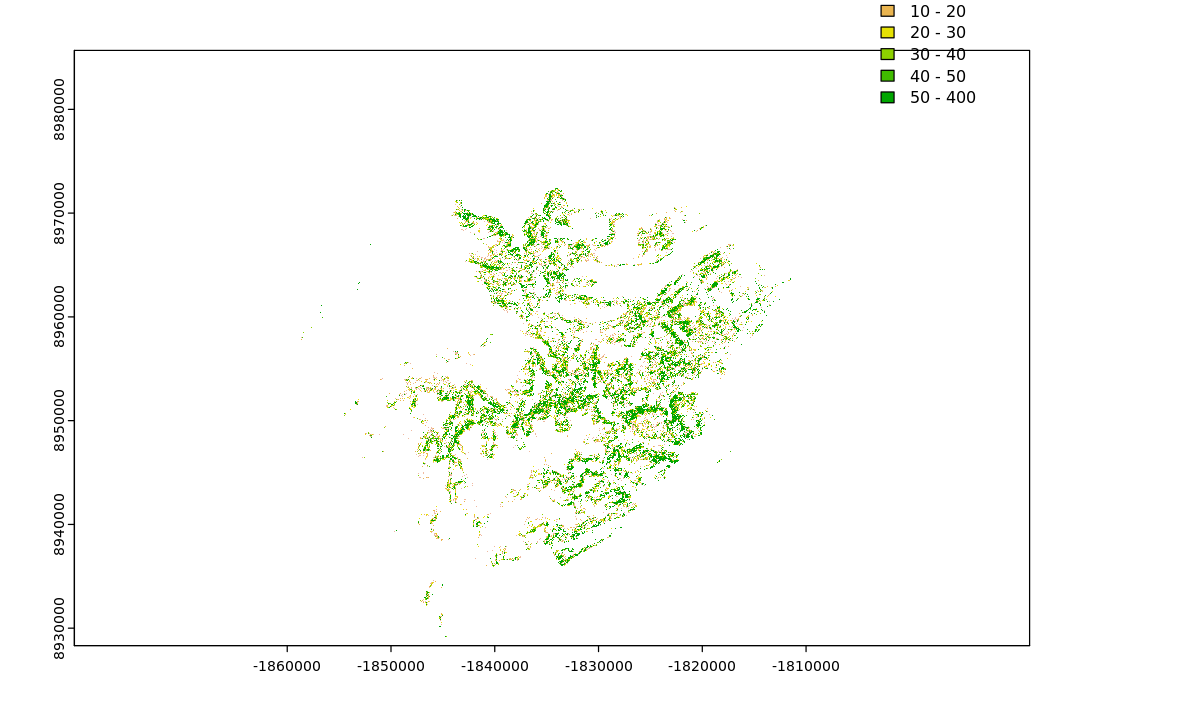

[1] "Map of residuals: ref - src"


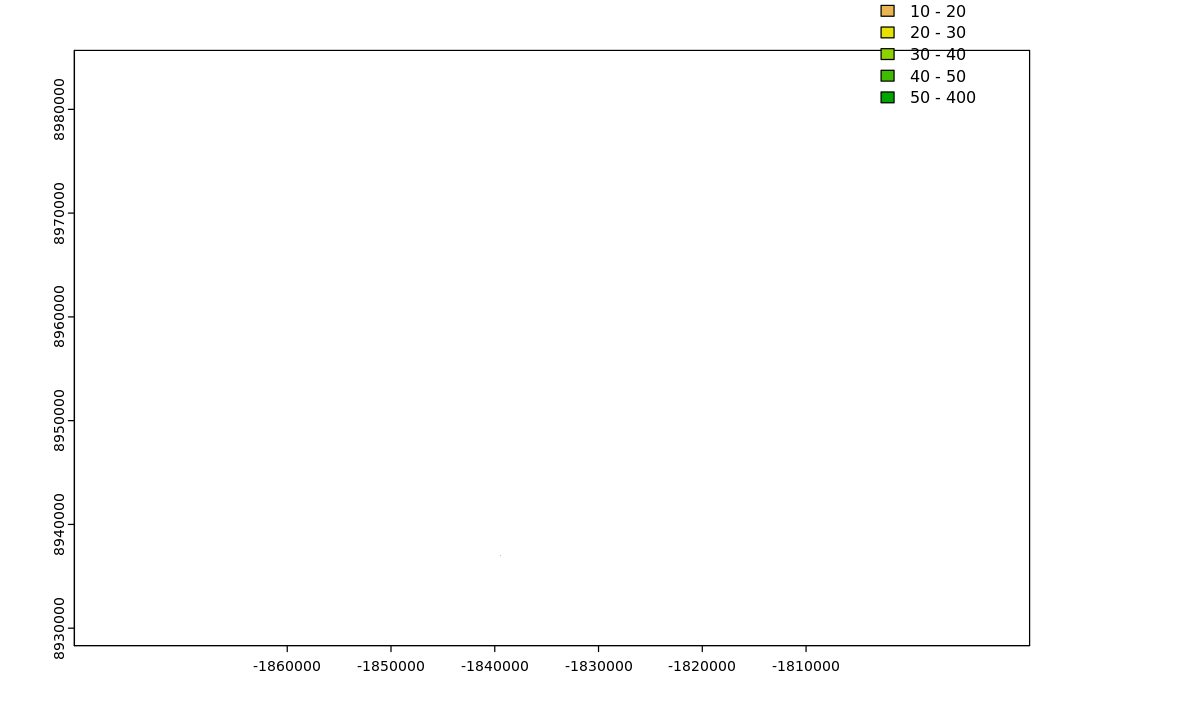

[1] "Map of residuals: ref - src"


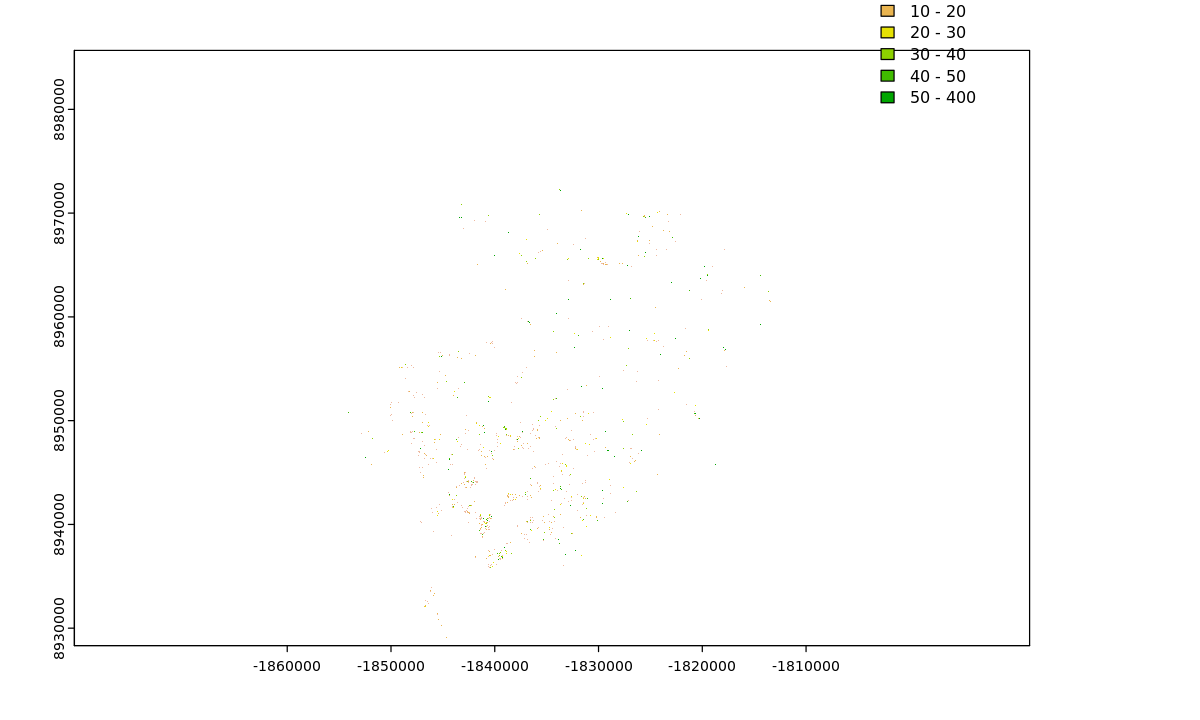

[1] "Map of residuals: ref - src"


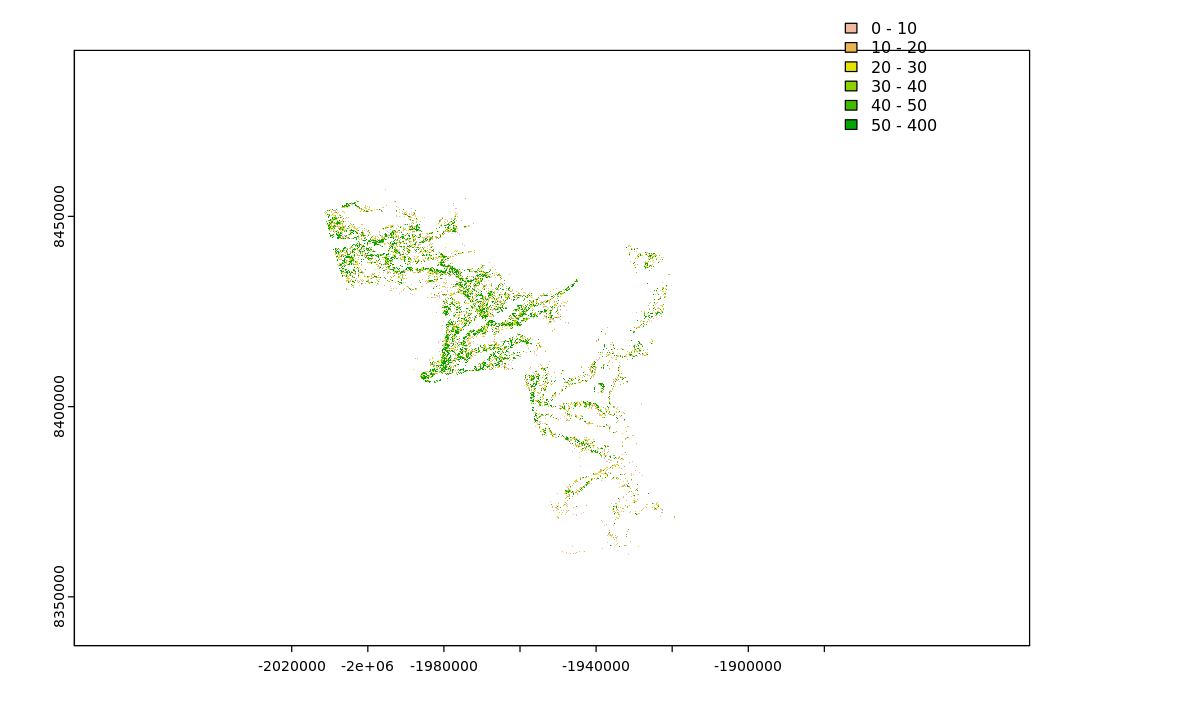

[1] "Map of residuals: ref - src"


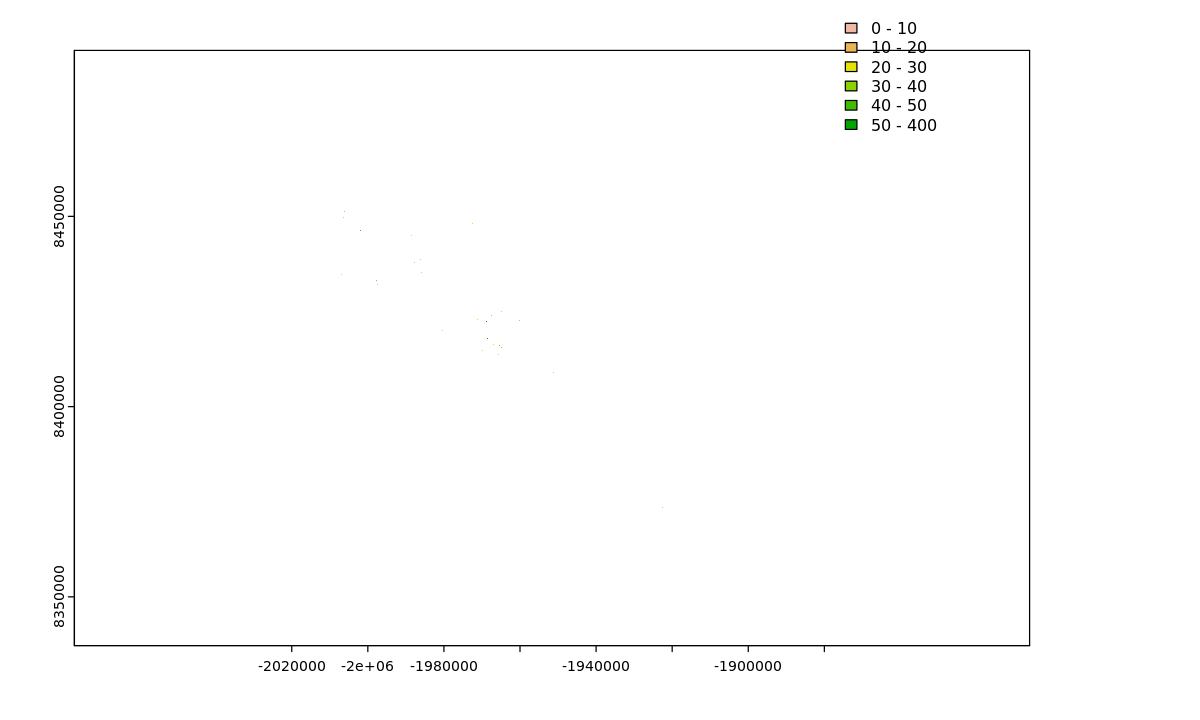

[1] "Map of residuals: ref - src"


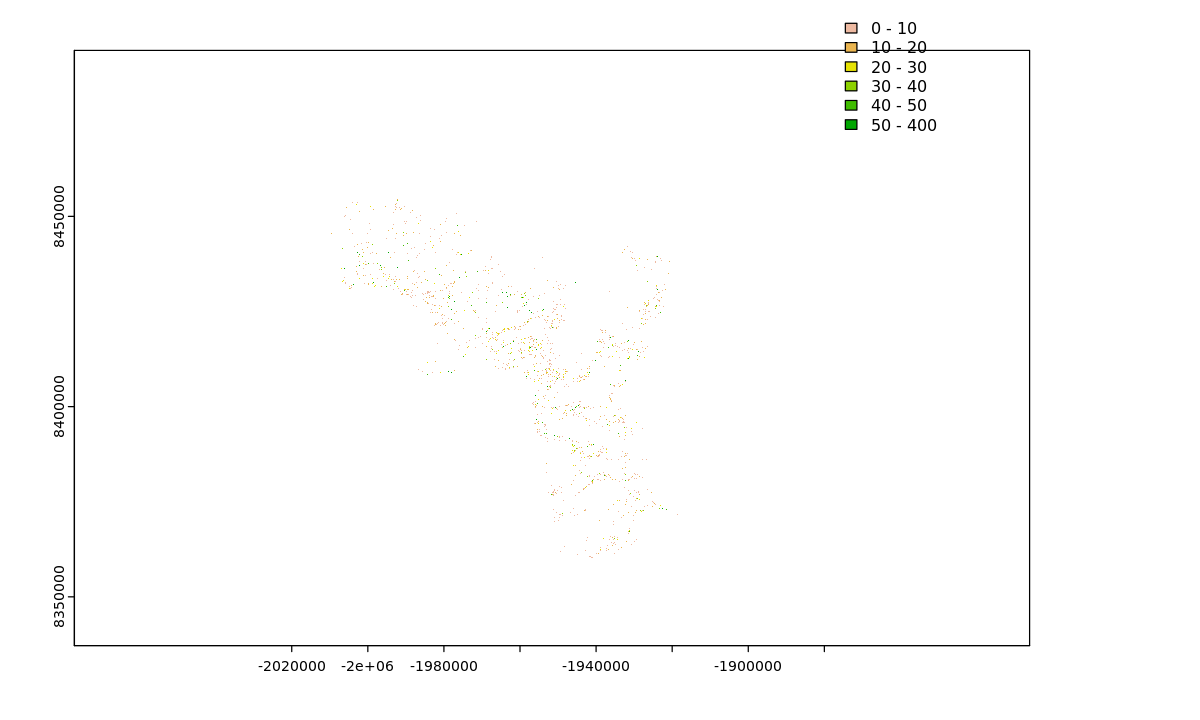

[1] "Map of residuals: ref - src"


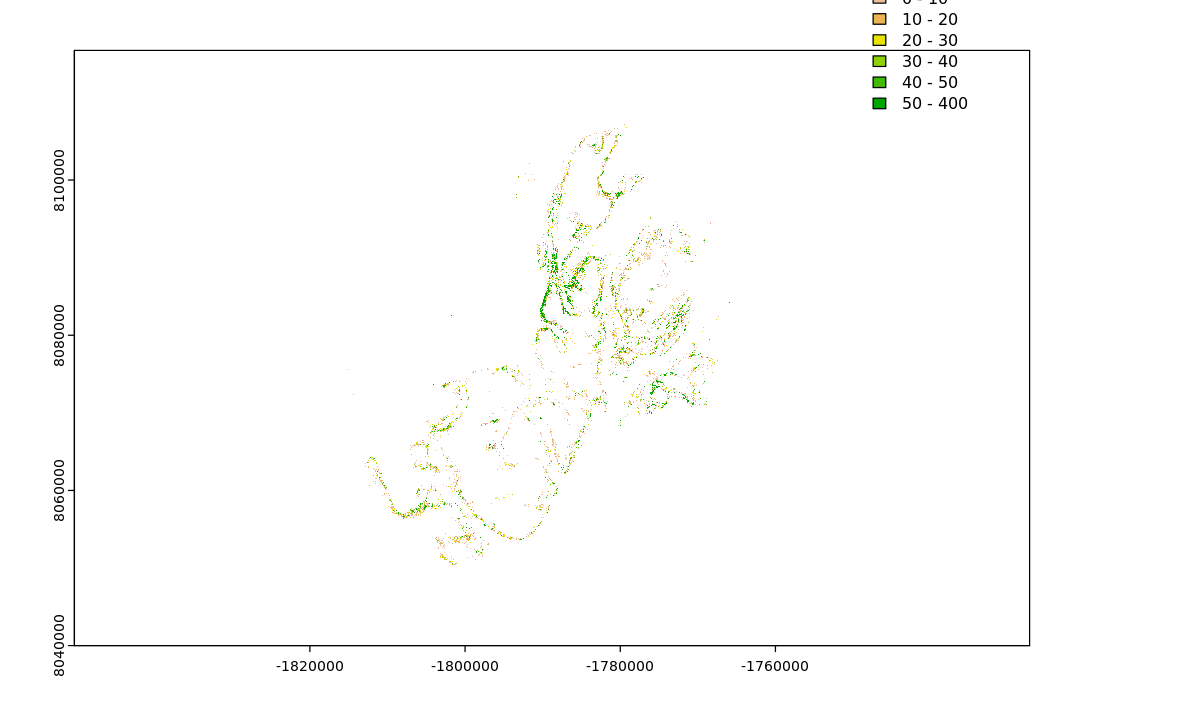

[1] "Map of residuals: ref - src"


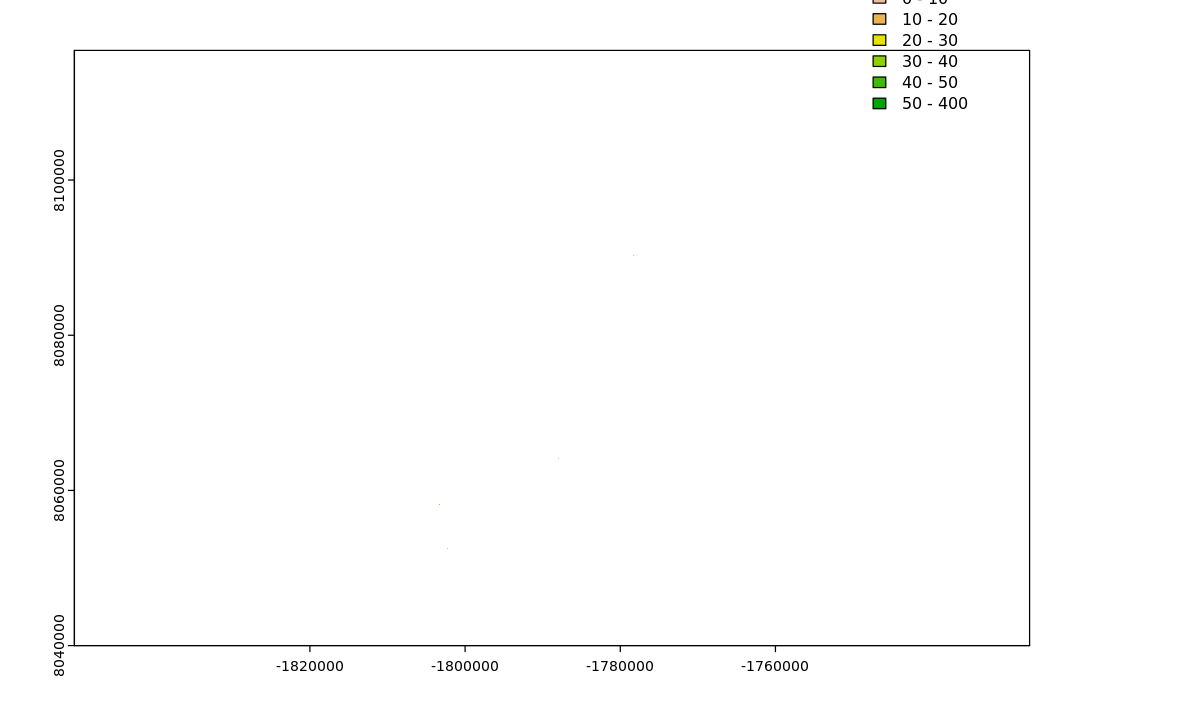

[1] "Map of residuals: ref - src"


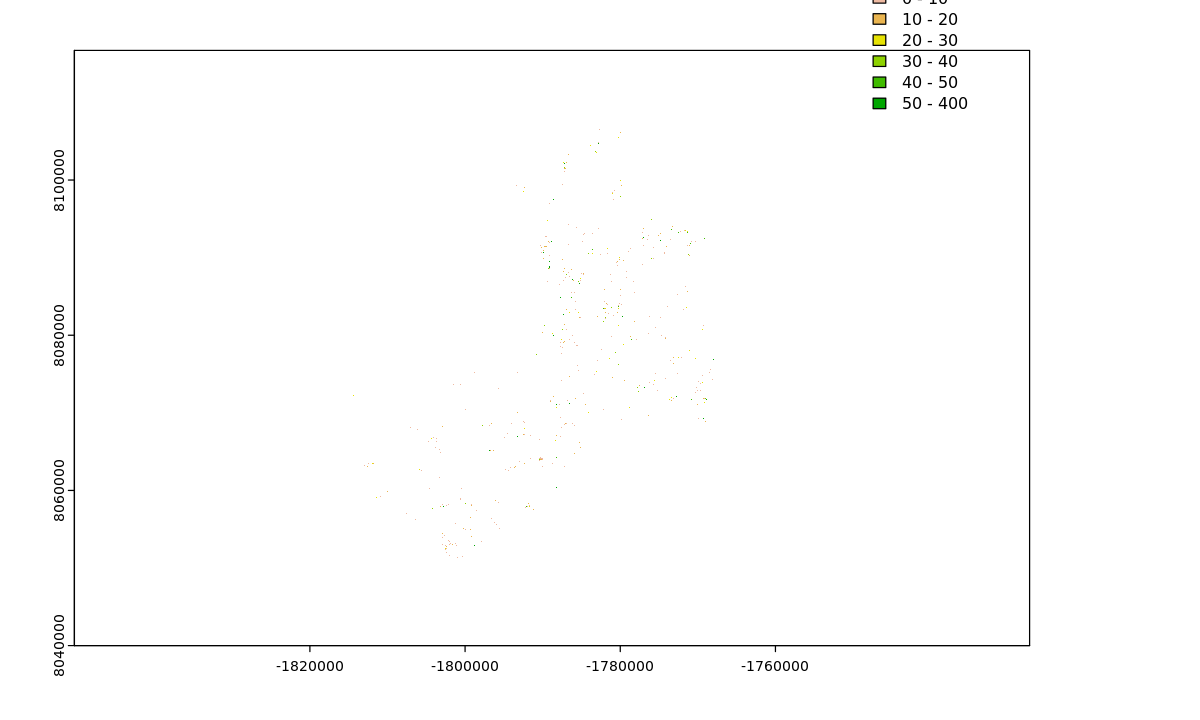

[1] "Map of residuals: ref - src"


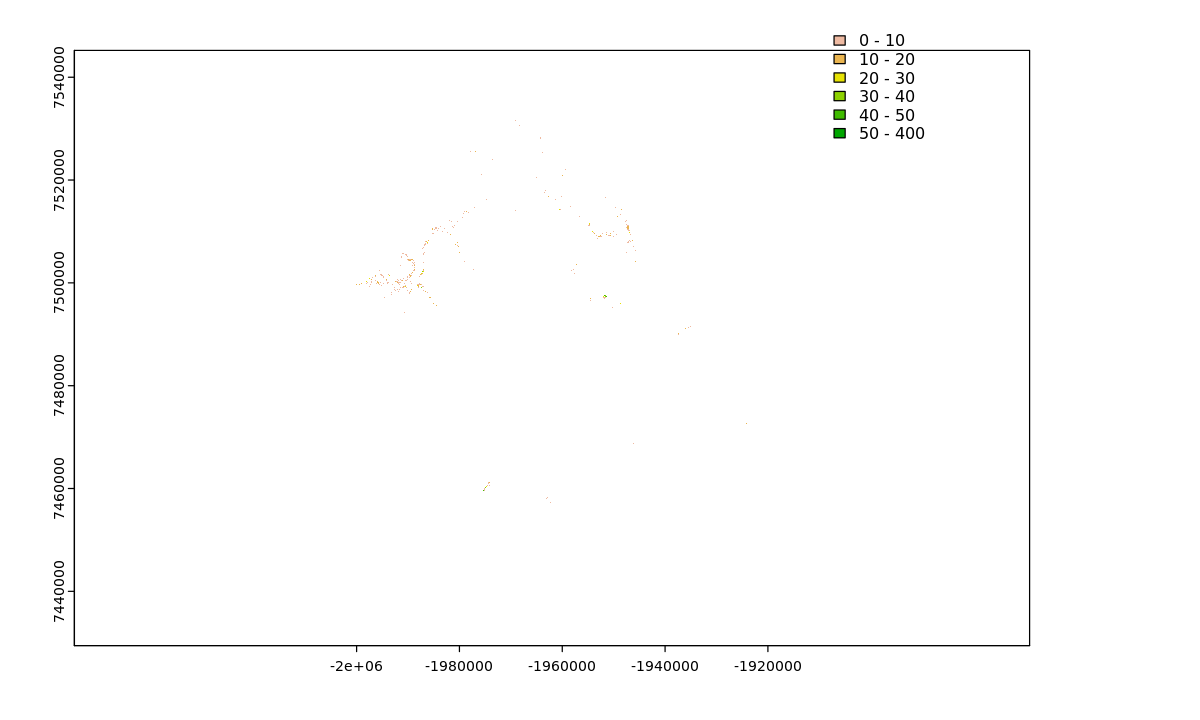

[1] "Map of residuals: ref - src"


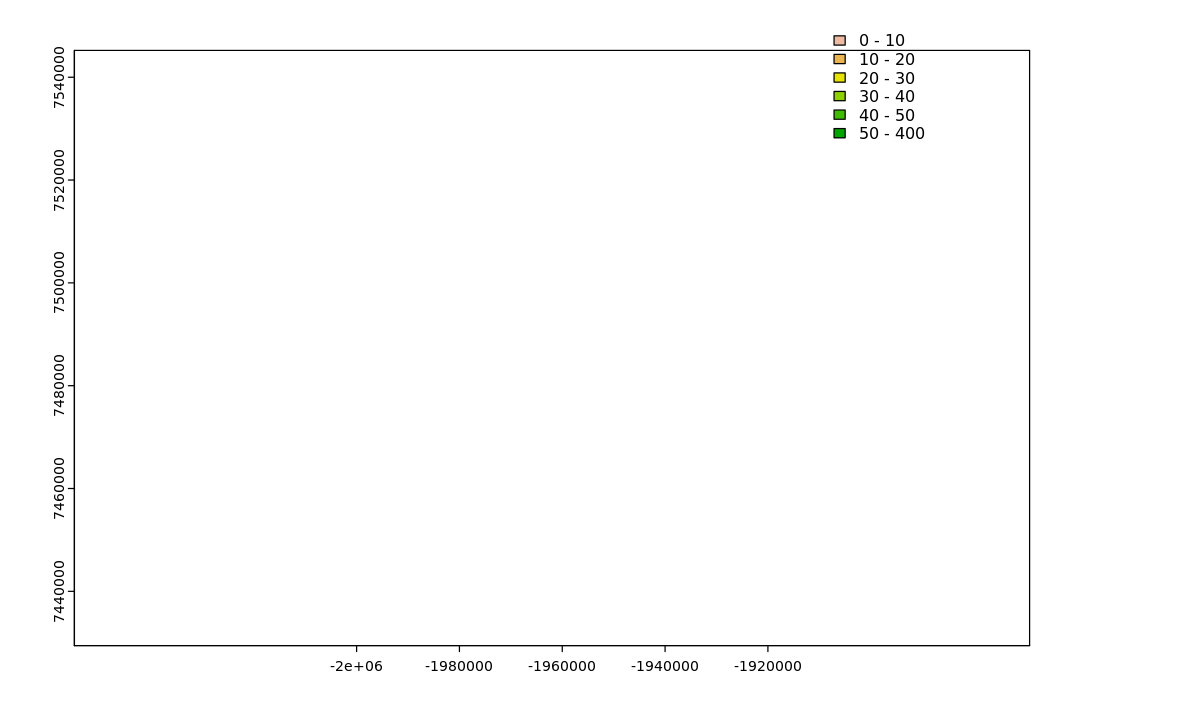

[1] "Map of residuals: ref - src"


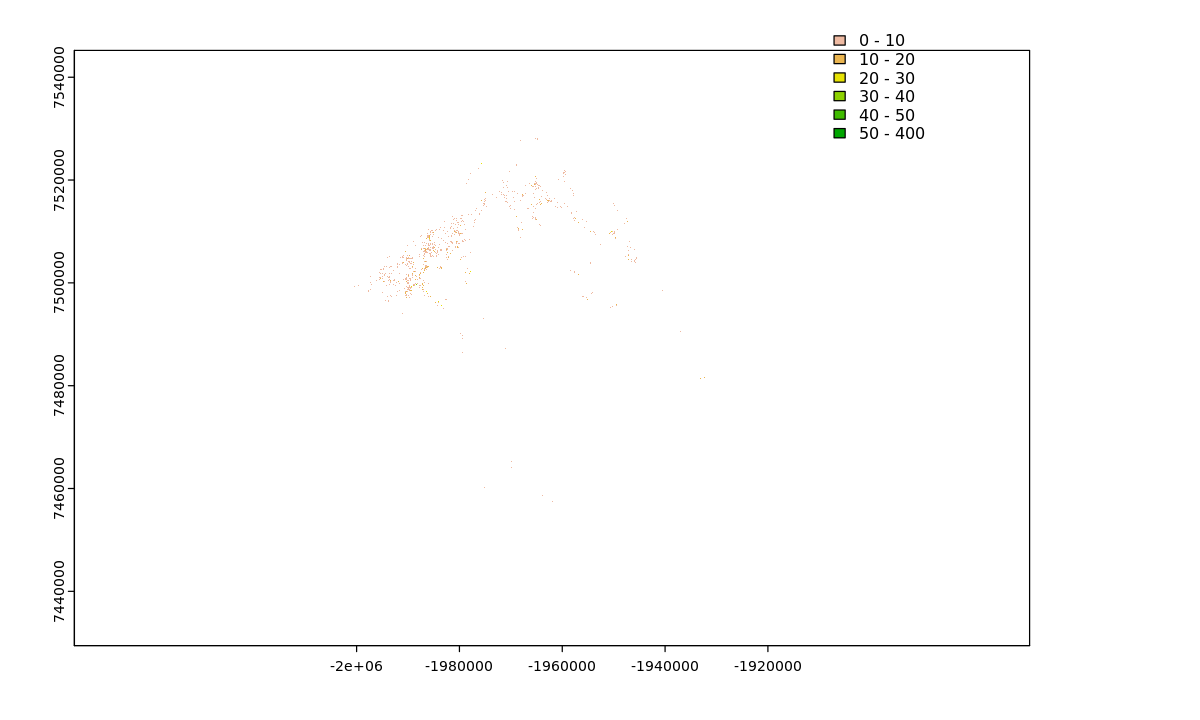

[1] "Map of residuals: ref - src"


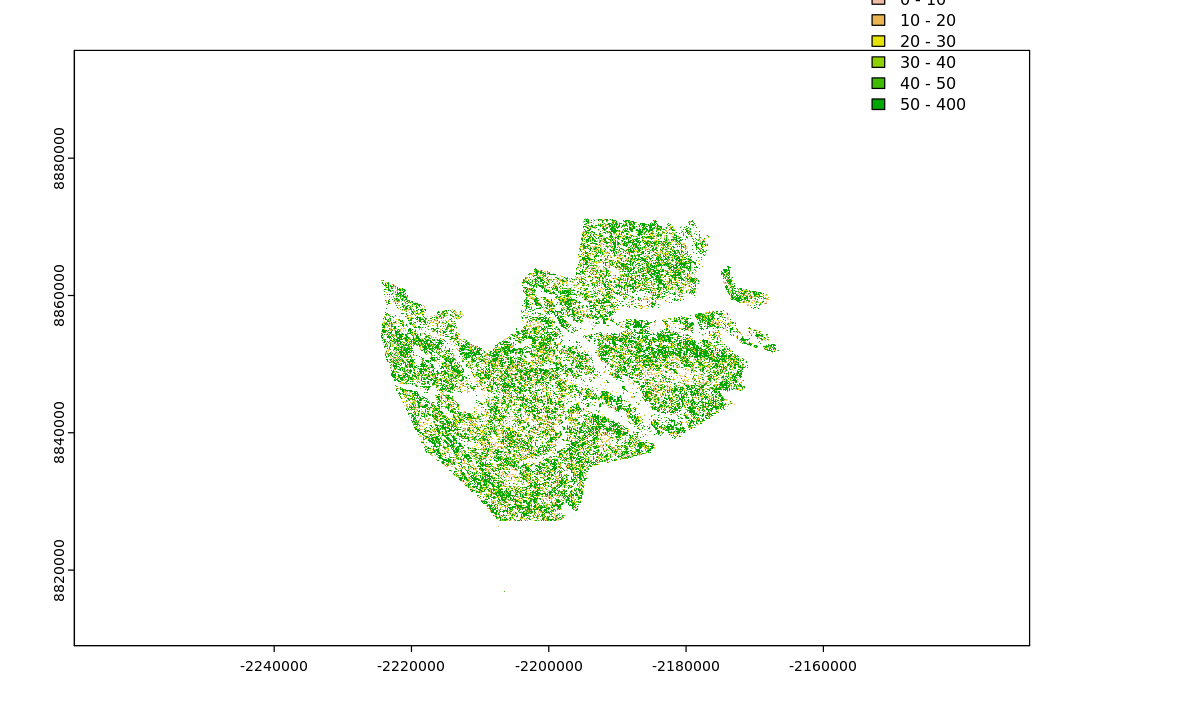

[1] "Map of residuals: ref - src"


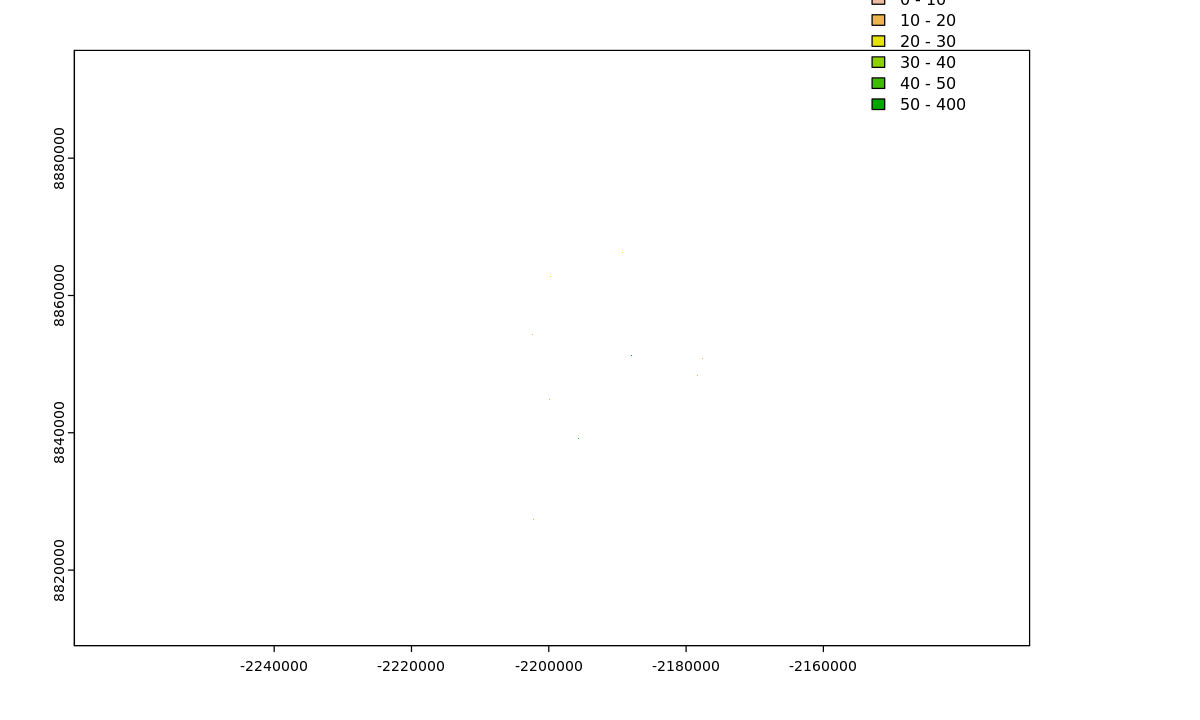

[1] "Map of residuals: ref - src"


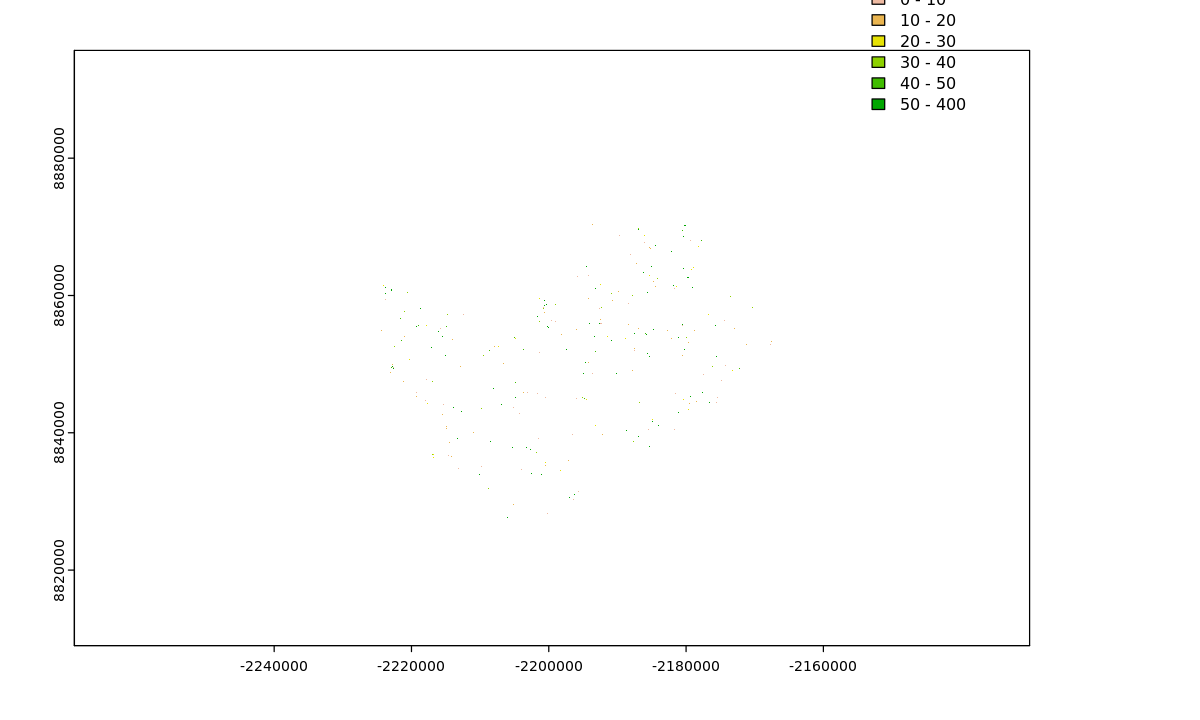

[1] "Map of residuals: ref - src"


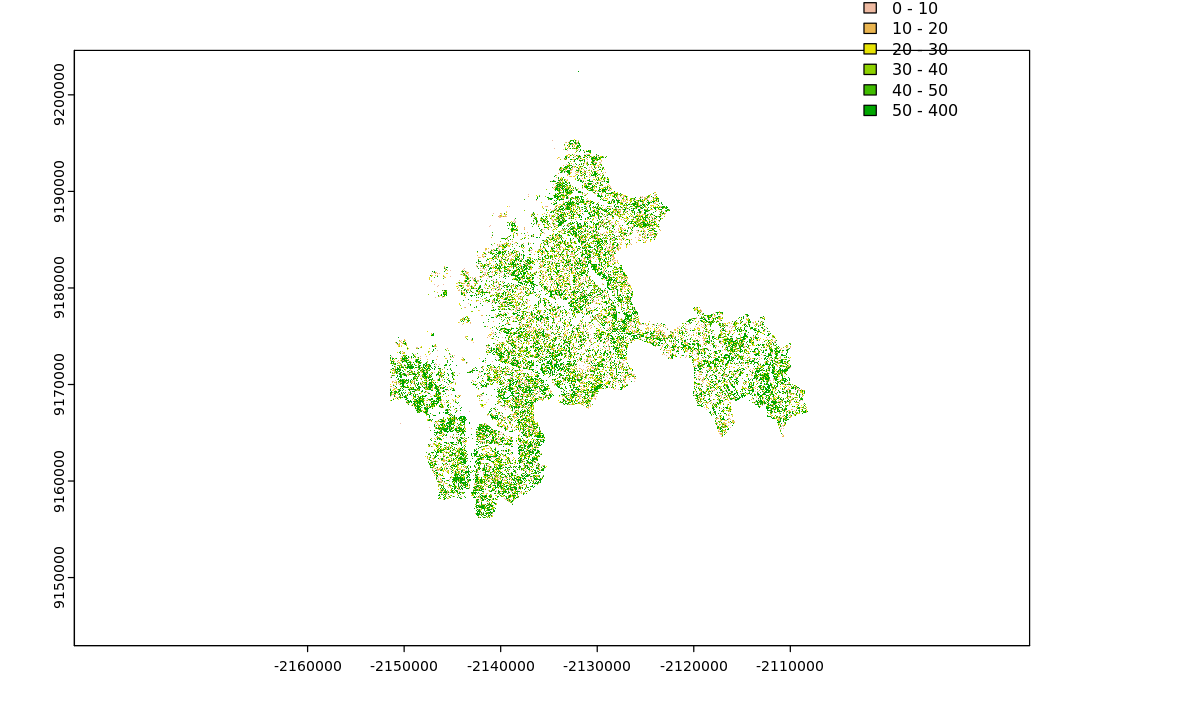

[1] "Map of residuals: ref - src"


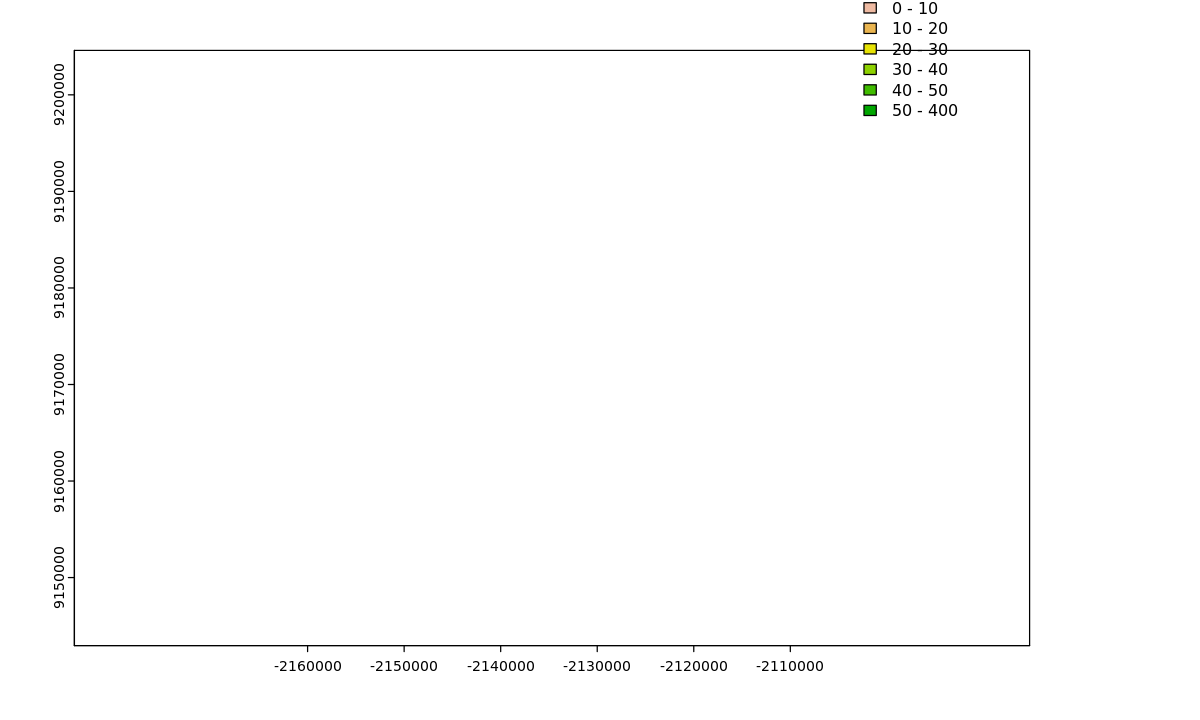

[1] "Map of residuals: ref - src"


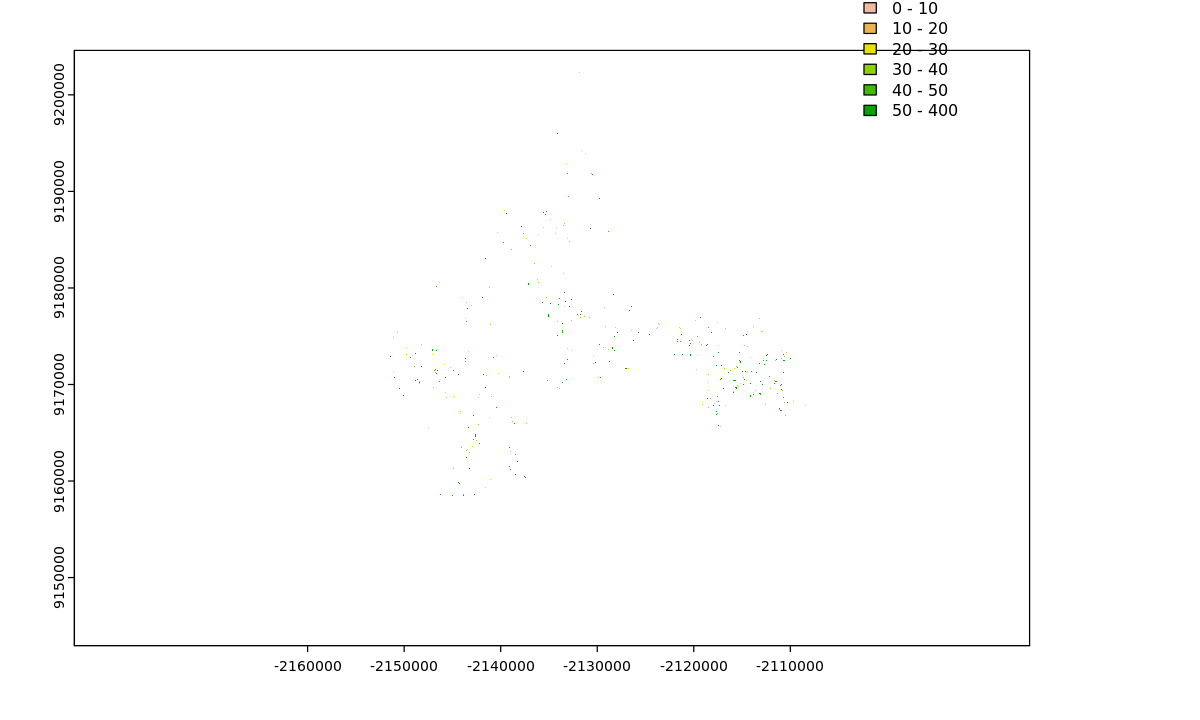

[1] "Map of residuals: ref - src"


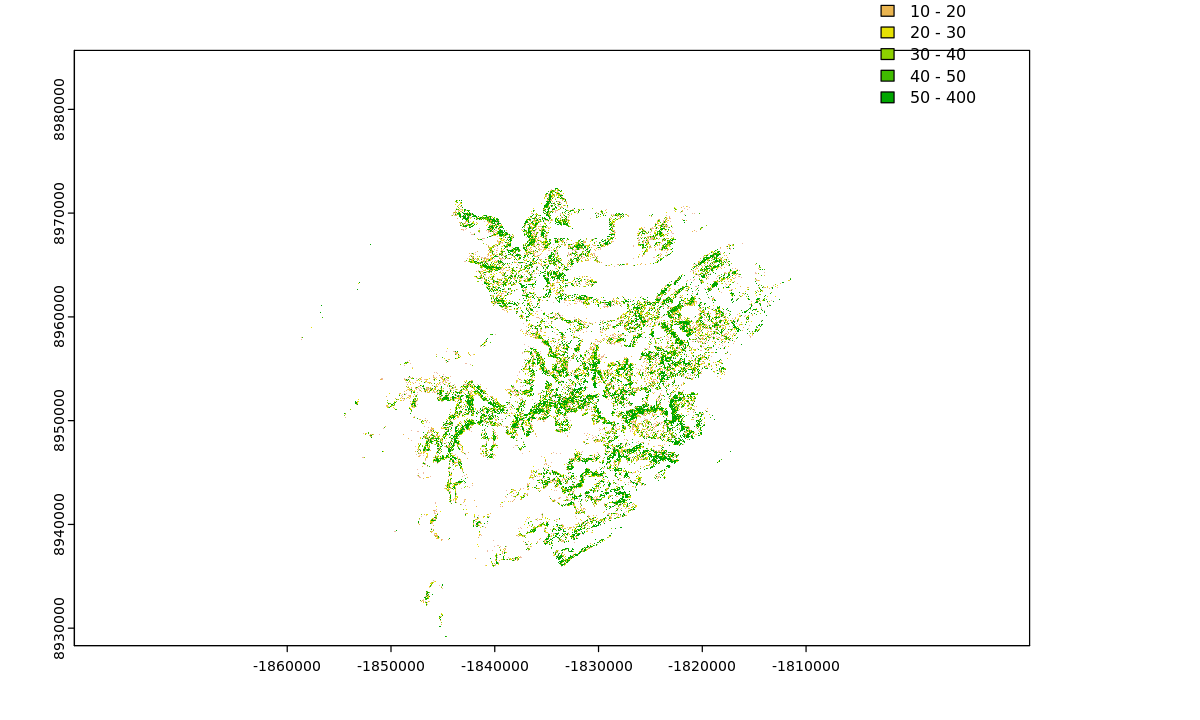

[1] "Map of residuals: ref - src"


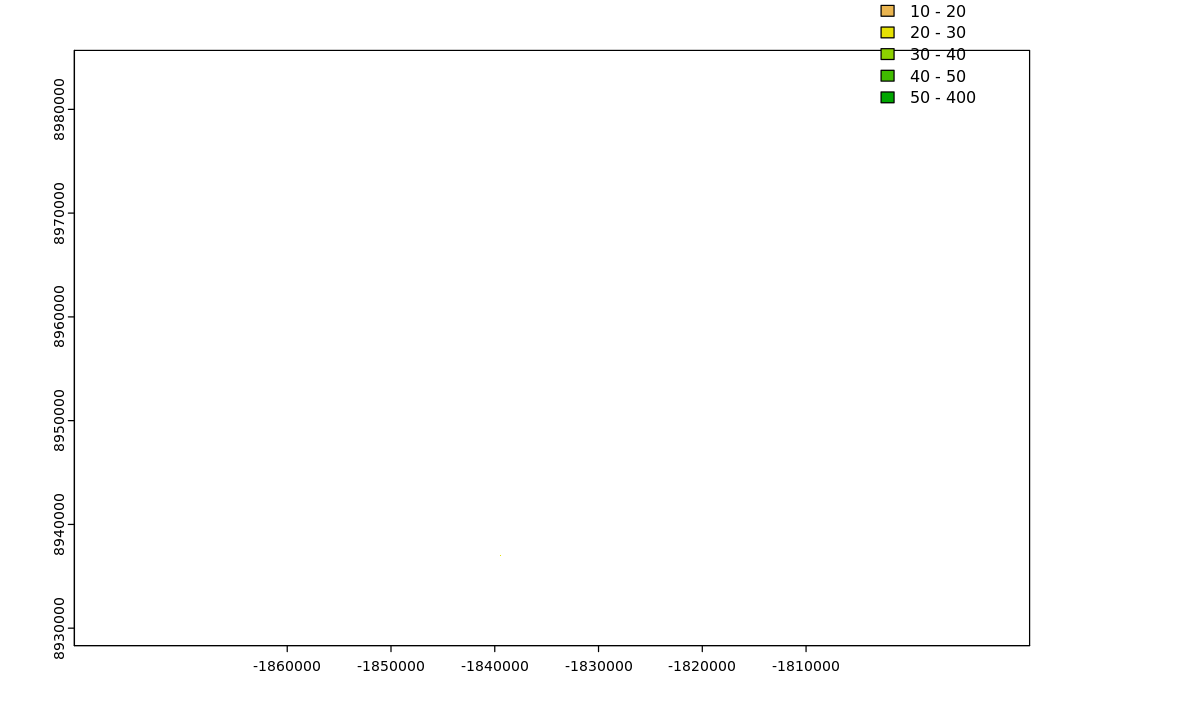

[1] "Map of residuals: ref - src"


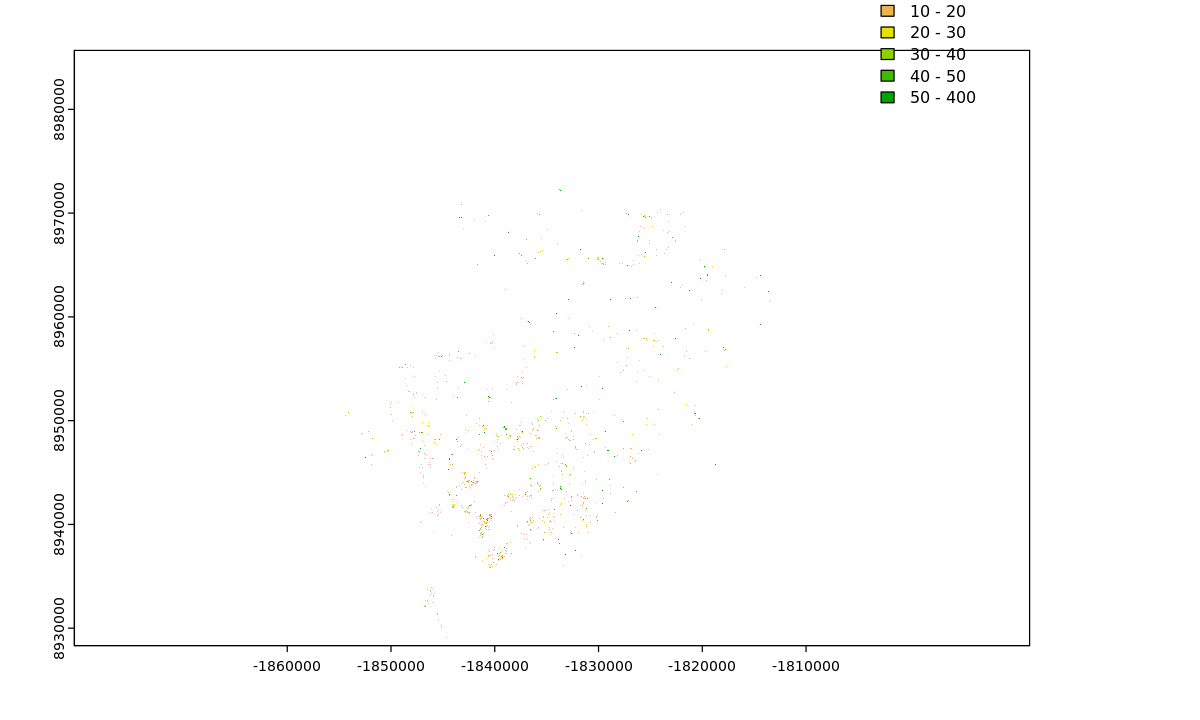

[1] "Map of residuals: ref - src"


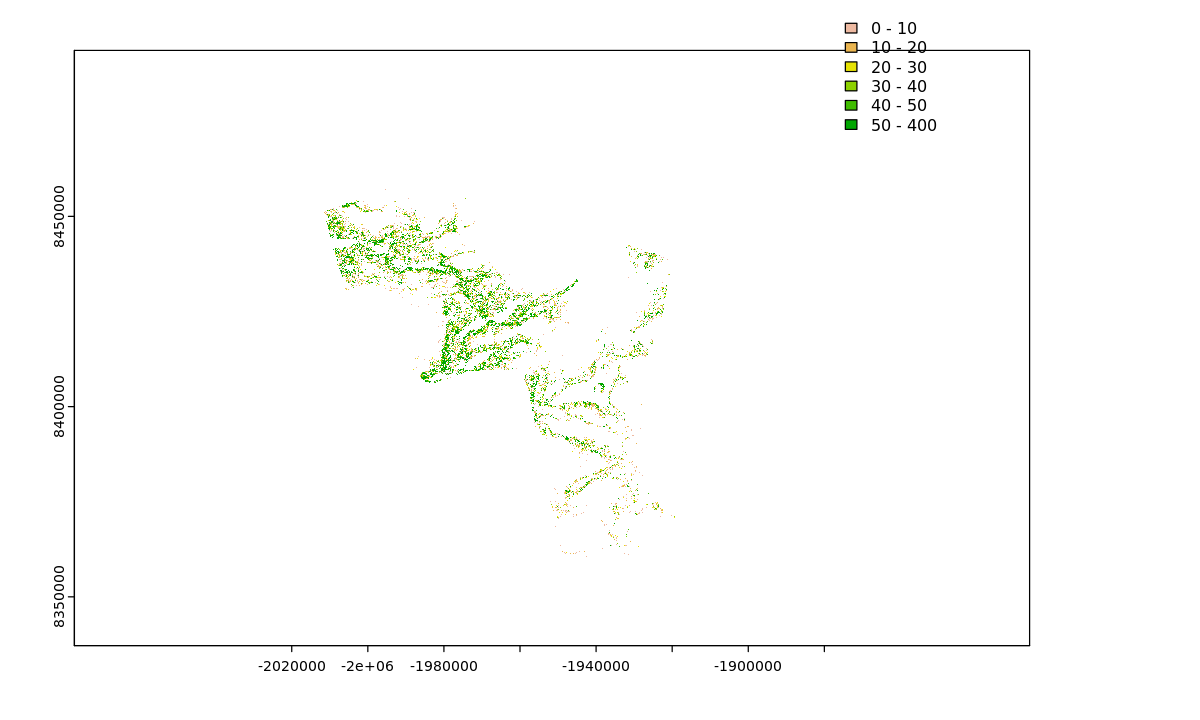

[1] "Map of residuals: ref - src"


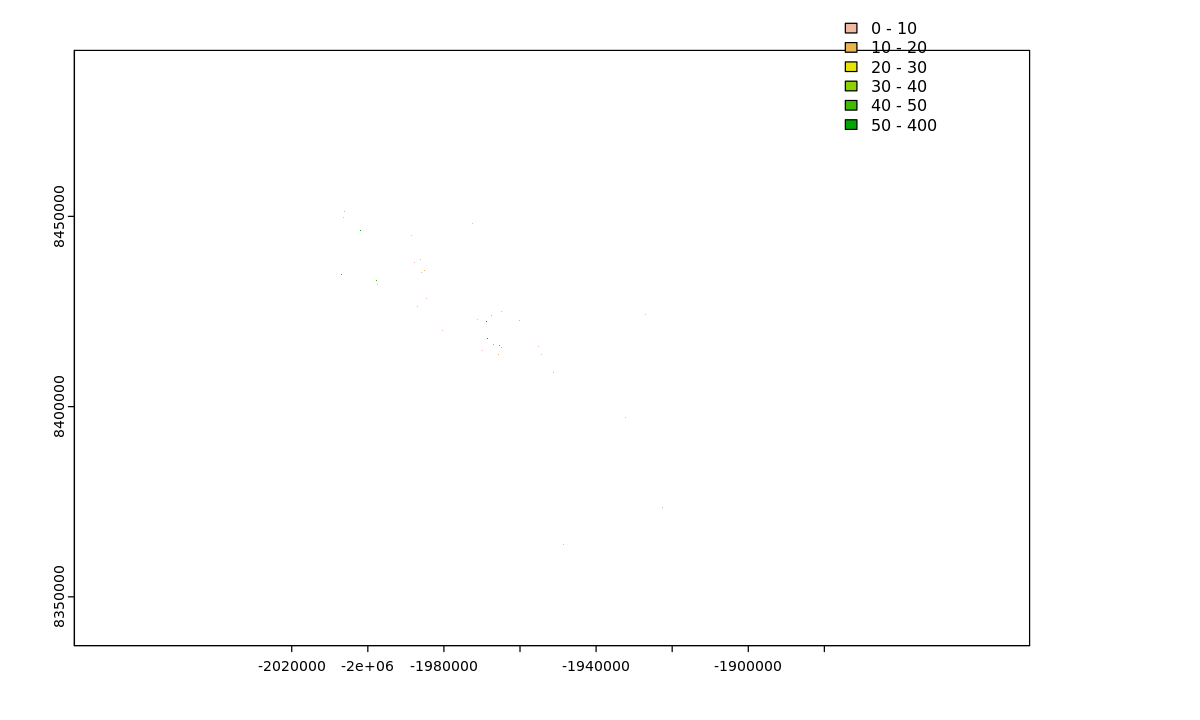

[1] "Map of residuals: ref - src"


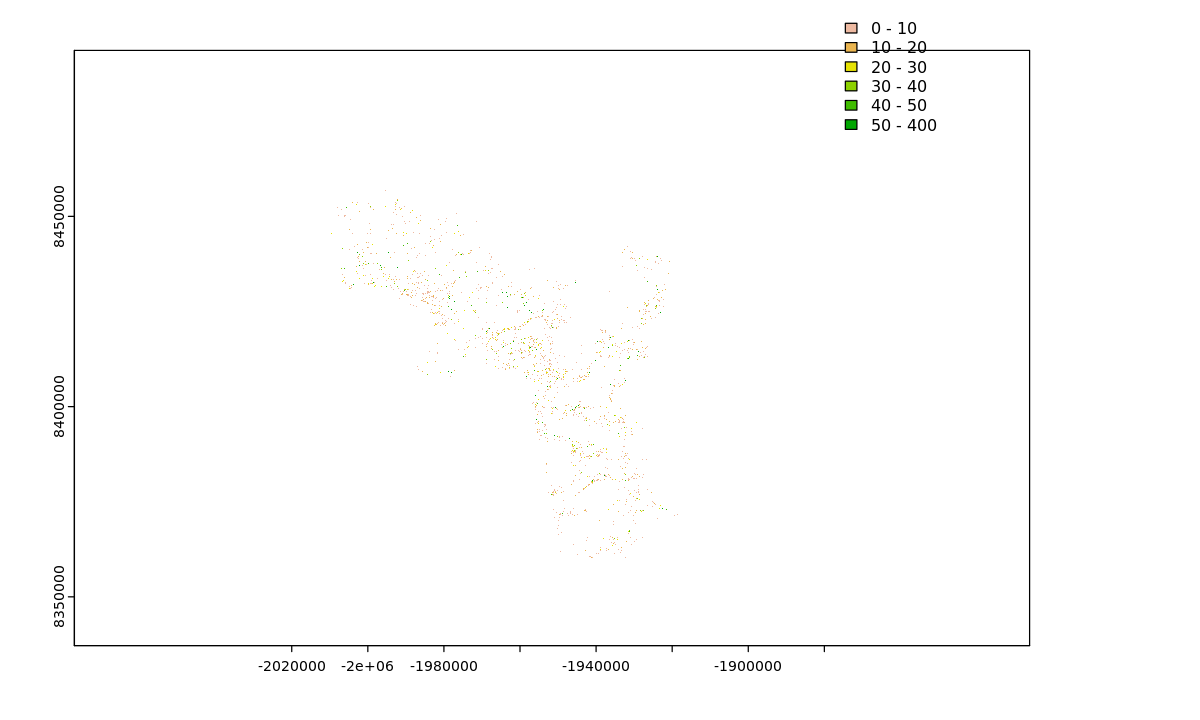

[1] "Map of residuals: ref - src"


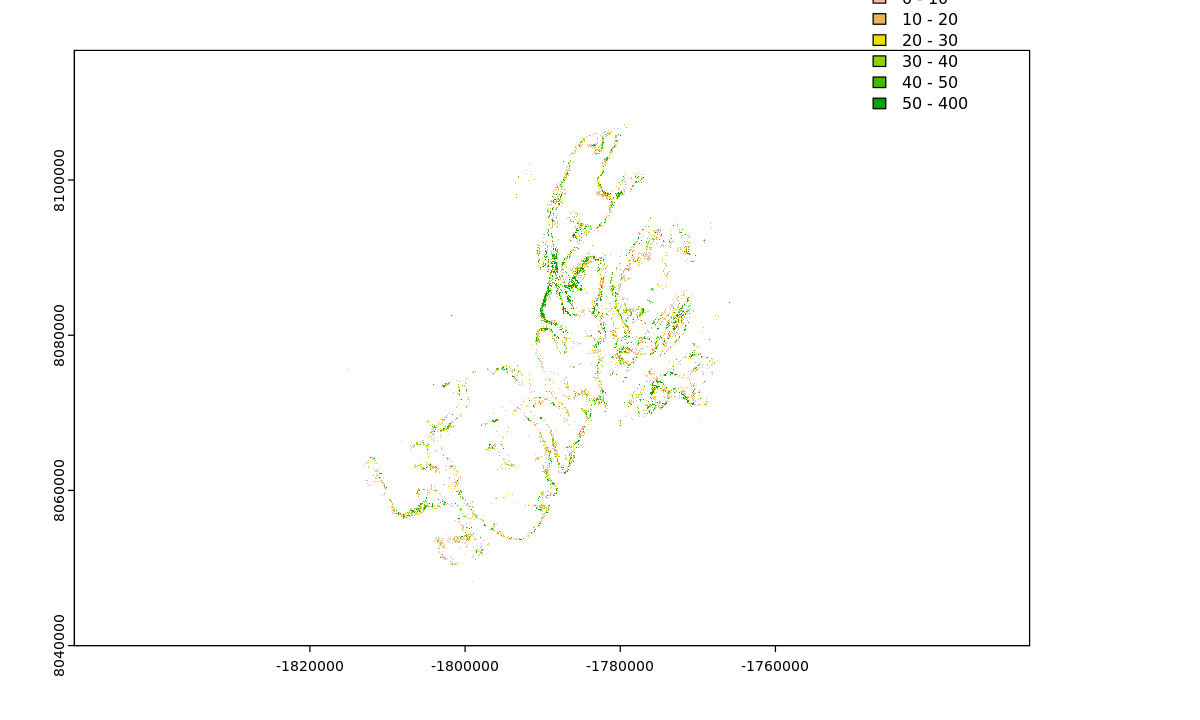

[1] "Map of residuals: ref - src"


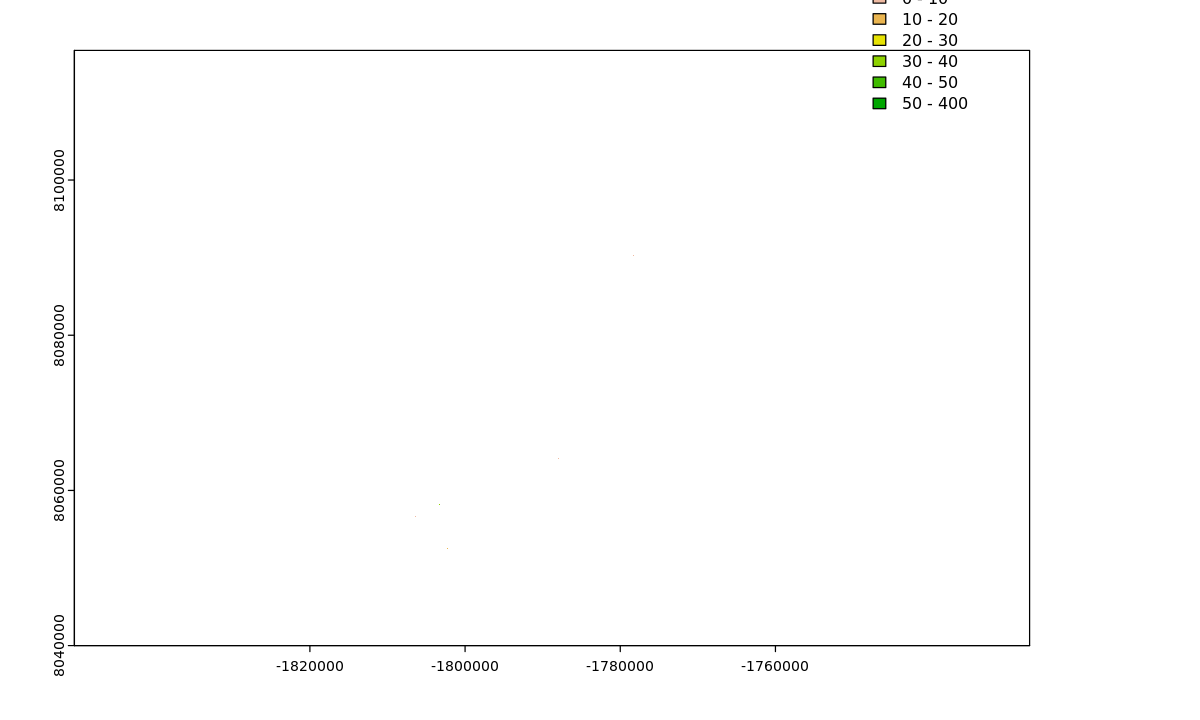

[1] "Map of residuals: ref - src"


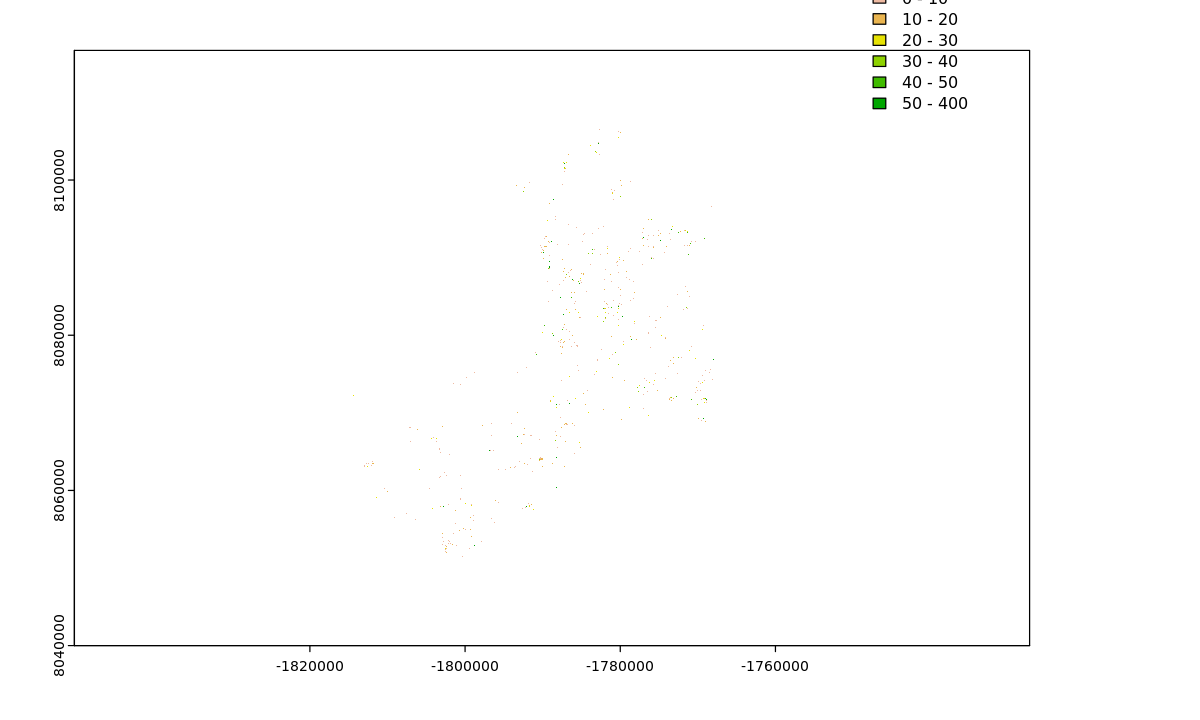

[1] "Map of residuals: ref - src"


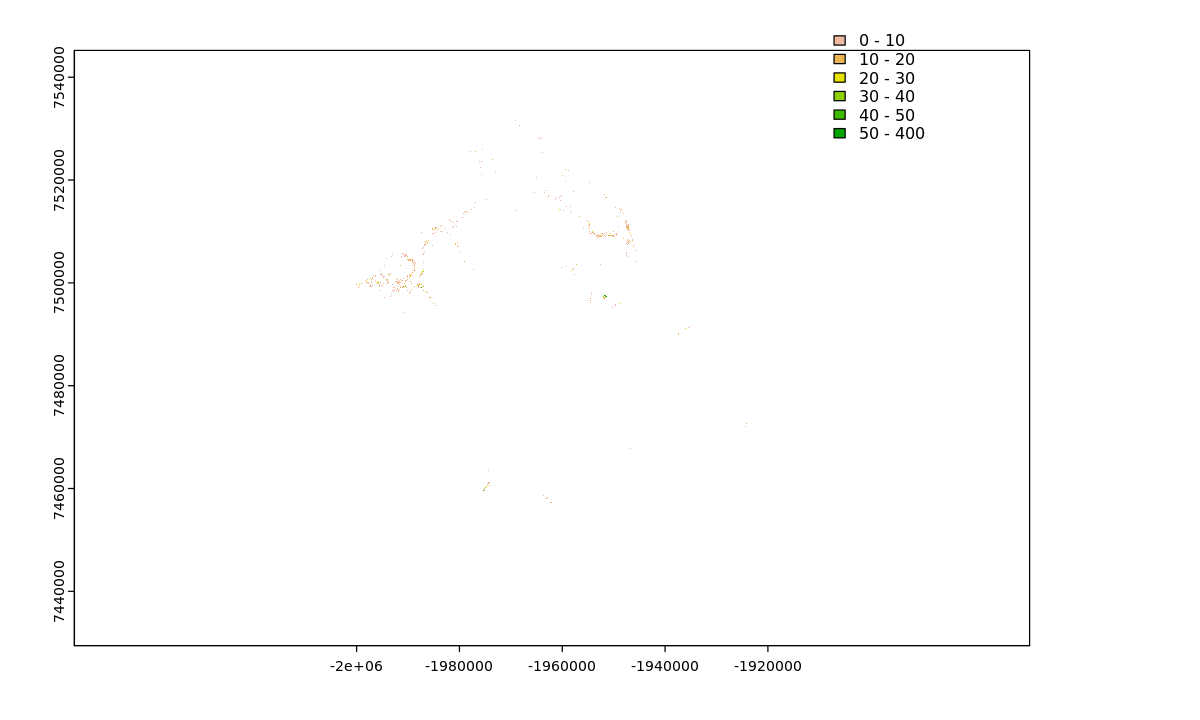

[1] "Map of residuals: ref - src"


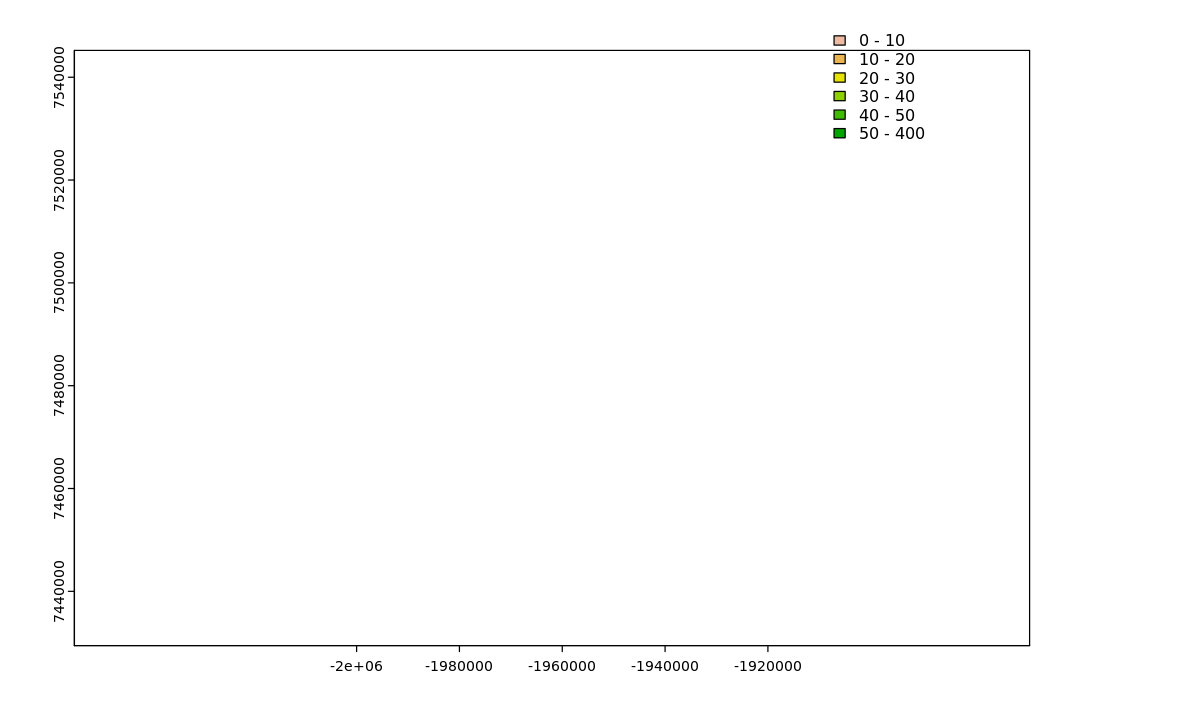

[1] "/projects/my-public-bucket/norway_test_data/results/results_all.csv"


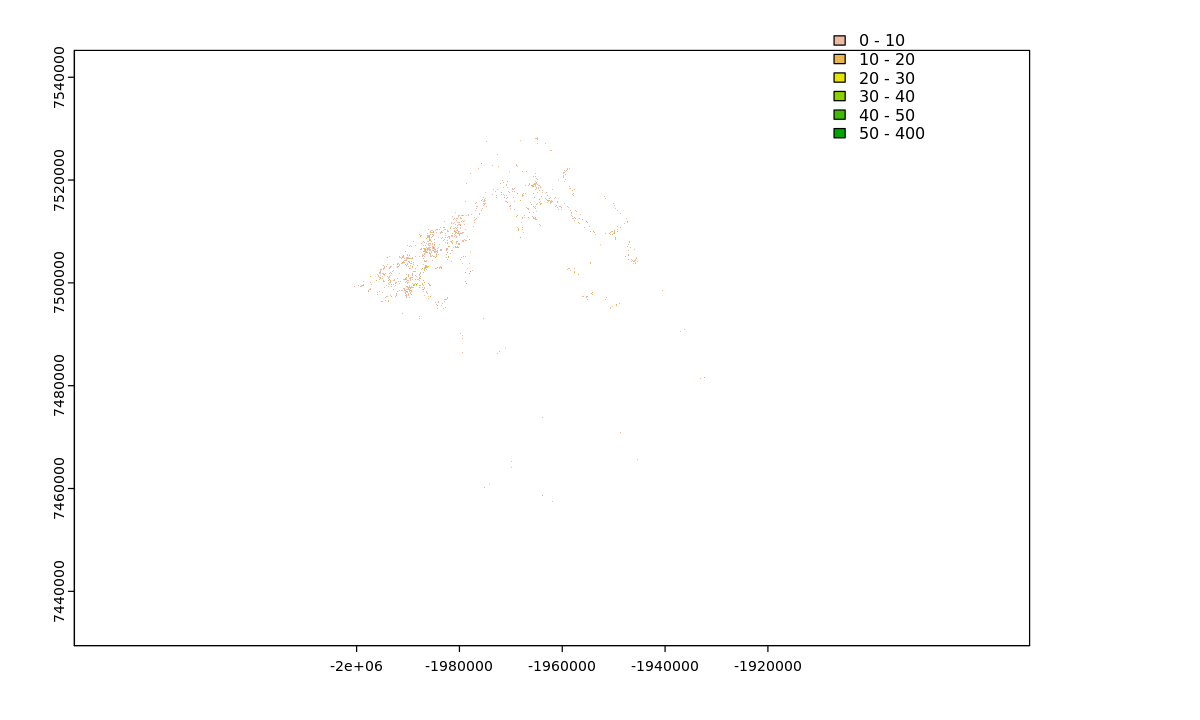

In [139]:
results_df_rhtype_list = list()

REGION = 'norway' # 'norway'
REGION_DIR = paste0('/projects/shared-buckets/nathanmthomas/validate_agb/', REGION)

for(RHTYPE in c('ground', 'noground')){
    
    PATTERN_STRING = paste0(".*boreal_agb_",RHTYPE,".*.tif$")
    SRC_FN_LIST = list.files(REGION_DIR, pattern = PATTERN_STRING, recursive = T, full.names = T )
    REF_FN_LIST = list.files(REGION_DIR, pattern = ".*_ref_AGB.*cog.tif$", recursive = T, full.names = T )
    LC_FN_LIST = list.files(REGION_DIR, pattern = ".*esa_worldcover_v100_2020_.*cog.tif$", recursive = T, full.names = T )
    LC_FOCAL_VAL_LIST = c(10, 20, 30)
    LC_FOCAL_NAME_LIST = c('trees', 'shrubs', 'grass')
    
    RESULTS_LIST = list()

    i = 0
    for(ref_fn in REF_FN_LIST){
        i = i + 1
        src_fn = SRC_FN_LIST[[i]]
        lc_fn = LC_FN_LIST[[i]]
        
        results_df_lctype_list = list()
        j = 0
        for(LC_FOCAL_VAL in LC_FOCAL_VAL_LIST){
            
            j = j + 1
            results = VALIDATE_RASTER(src_fn, ref_fn, lc_fn, LC_FOCAL_VAL = LC_FOCAL_VAL, REF_BAND_NUM=AGB_band )
            results$RHTYPE = RHTYPE
            results$LCTYPE = LC_FOCAL_NAME_LIST[j]
            results_df_lctype_list[[j]] = results
        }
        #results$RHTYPE = RHTYPE
        #RESULTS_LIST[[i]] = results
        results_df_lctype = do.call('rbind', results_df_lctype_list)
        results_df_type_list[[i]] = results_df_lctype

    }
    # Bind all result dfs from this RHTYPE into a single data frame
    results_df_rhtype = do.call('rbind', results_df_type_list)
    # Update a list of the RHTYPE data frames
    results_df_rhtype_list[[RHTYPE]] = results_df_rhtype
}
# Bind all RHTYPE data frames into a single df
results_df_all = do.call('rbind', results_df_rhtype_list)
results_df_all$REGION = REGION

# Write results by region
results_df_all = results_df_all %>% separate(REF_FN, c('REF_DIR', 'SITE'), sep=paste0(REGION,'/'))
csv_dir <- paste0('/projects/my-public-bucket/',REGION,'_test_data/results/')
out_name <- paste0(csv_dir, 'results_all', '.csv')
print(out_name)
write.csv(results_df_all, file=out_name)

### Plot the results

In [141]:
df_alaska_results = read.csv('/projects/my-public-bucket/alaska_test_data/results/results_all.csv')
df_norway_results = read.csv('/projects/my-public-bucket/norway_test_data/results/results_all.csv')

results_df_all = rbind(df_alaska_results, df_norway_results)

In [142]:
head(results_df_all)

,X,ID,RMSE,BIAS,RMSE_rel,BIAS_rel,SRC_FN,REF_DIR,SITE,RHTYPE,LCTYPE,REGION
,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ground.ground.1,NA,37.92666,7.939206,66.82961,13.98947,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_1_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_1_cog.tif,ground,trees,alaska
2,ground.ground.2,NA,25.25957,-8.180020,44.50925,-14.41381,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_1_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_1_cog.tif,ground,shrubs,alaska
3,ground.ground.3,NA,25.19175,-10.236774,44.38975,-18.03796,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_1_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_1_cog.tif,ground,grass,alaska
4,ground.noground.1,NA,24.09834,-3.803736,191.75275,-30.26669,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_2_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_2_cog.tif,ground,trees,alaska
5,ground.noground.2,NA,15.54719,-12.796597,123.71047,-101.82373,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_2_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_2_cog.tif,ground,shrubs,alaska
6,ground.noground.3,NA,15.14883,-13.124797,120.54069,-104.43525,/projects/shared-buckets/nathanmthomas/validate_agb/alaska/boreal_agb_ground_2_cog.tif,/projects/shared-buckets/nathanmthomas/validate_agb/,northamerica_ref_AGB_2_cog.tif,ground,grass,alaska


Using X, ID, SRC_FN, REF_DIR, SITE, RHTYPE, LCTYPE, REGION as id variables



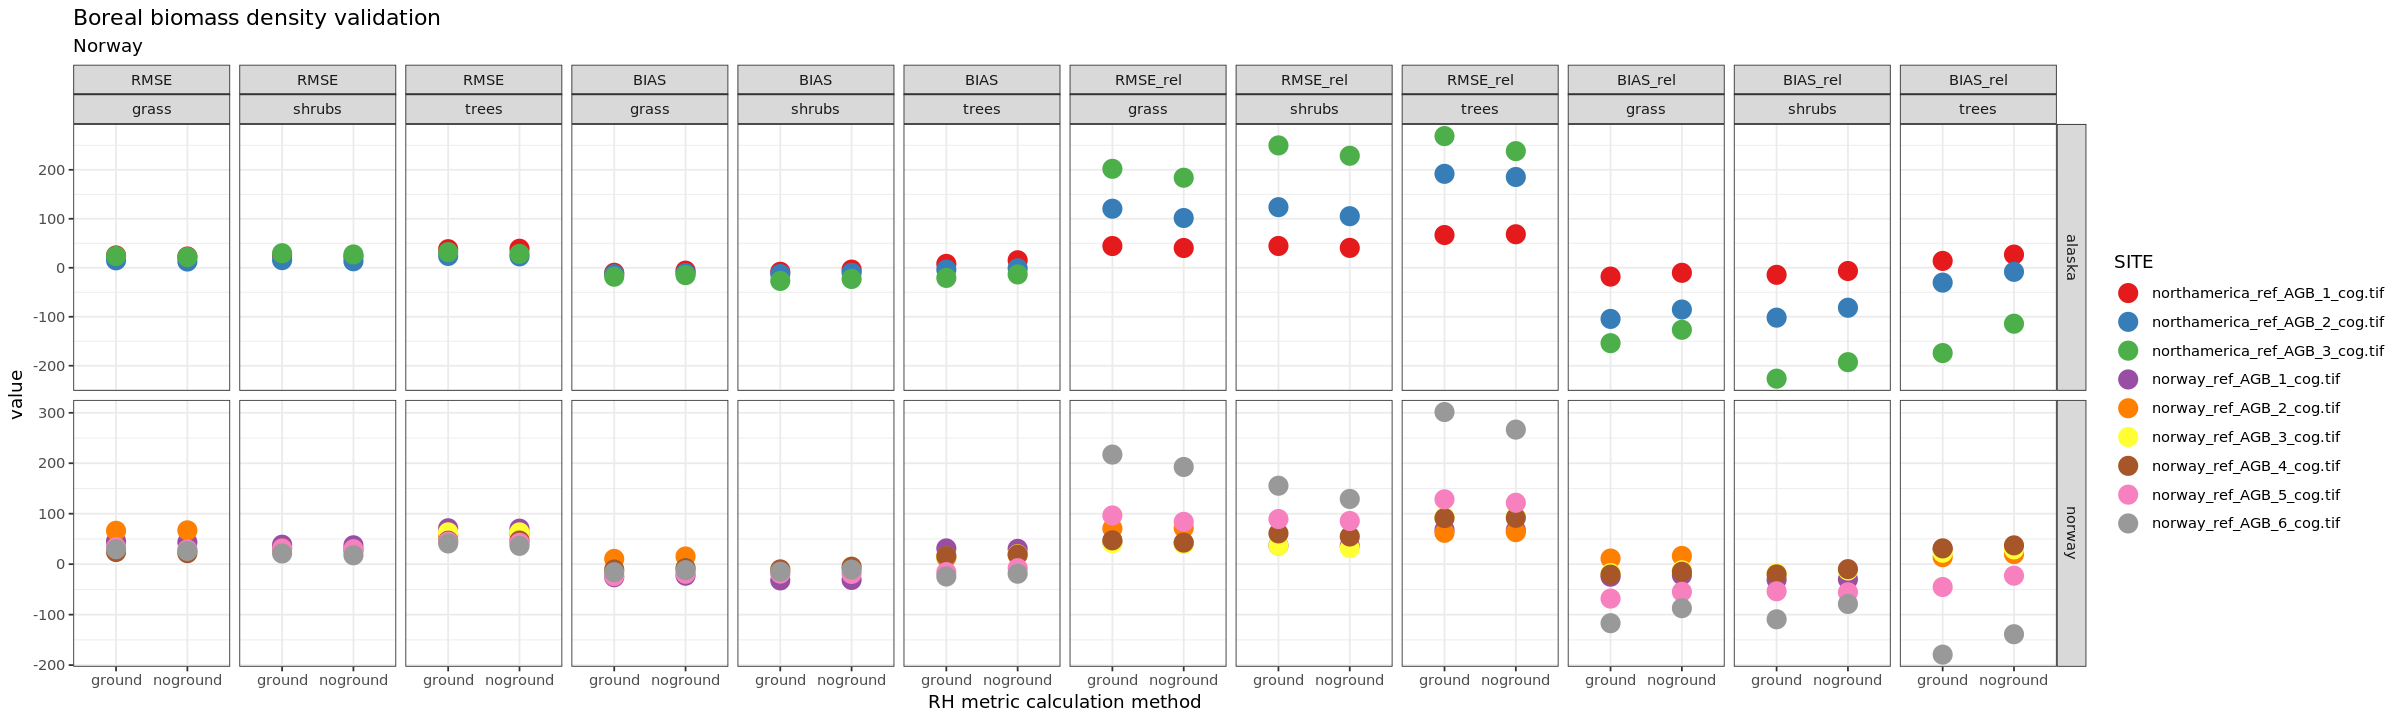

In [149]:
options(repr.plot.height = 6, repr.plot.width = 20, warn=-1)

reshape2::melt(results_df_all, id_vars=c(REGION, SITE, RHTYPE, LCTYPE), melt_vars = c(RMSE, BIAS)) %>%
    ggplot() +
        geom_point(aes(x = RHTYPE, y=value, color=SITE), size=5) + 
        scale_color_brewer(palette='Set1') + 
        theme_bw() + 
        facet_grid(REGION ~ variable+LCTYPE, scales='free') +
        labs(title='Boreal biomass density validation', subtitle= 'Norway', x='RH metric calculation method')


In [46]:
csv_dir <- '/projects/my-public-bucket/norway_test_data/results/'
out_name <- paste0(csv_dir, 'results_all', '.csv')
print(out_name)
#results <- round(results, 2)
write.csv(results_df_all, file=out_name)

[1] "/projects/my-public-bucket/norway_test_data/results/results_all.csv"
